## 1. Importar Librerias

In [1]:
# -- Librerias Principales --
import os
import pandas as pd
import requests
import numpy as np
import datetime
import math
import json
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf

# -- Librerias para Graficas --
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

2025-03-23 09:48:02.460336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 09:48:02.682129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-23 09:48:02.682162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-23 09:48:02.712564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 09:48:02.782527: I tensorflow/core/platform/cpu_feature_guar

## 2. Función para obtener token de autenticación en ThingsBoard.

In [2]:
def get_token(thingsboard_host, admin_username, admin_password):
    url = f"{thingsboard_host}/api/auth/login"
    payload = {"username": admin_username, "password": admin_password}
    response = requests.post(url, json=payload)
    
    if response.status_code == 200:
        return response.json().get("token")
    return None

## 3. Función para obtener datos de dispositivo, con API de Thingsboard.

In [3]:
def query_telemetry_data(thingsboard_host, device_id, sensor_keys, auth_token):

    # Convertir la fecha a timestamp en segundos y luego a milisegundos: 1741551815148 = 2025-03-09 20:23:35.148
    # Fecha y hora inicial desde cuando tenemos datos simulados
    init_date = datetime.datetime(year=2025, month=3, day=12, hour=0, minute=0, second=0)  # 1 de enero de 2023 a las 12:00:00
    hours = 24 # Horas de datos a consultar
    startTs = int(init_date.timestamp() * 1000) # Fecha y hora inicial para la consulta de datos
    endTs = startTs + (1000 * 60 * 60) * hours # Fecha y hora final de consulta, Aca damos la fecha inicial + unas horas adicionales
    
    print("|--------------------------------------------------------------------------------------------------|")
    print("Fecha y Hora Inicial y Final de consulta (telemetría): {}")
    print("Desde:", startTs, "=>", datetime.datetime.fromtimestamp(startTs/1000))
    print("Hasta:", endTs, "=>", datetime.datetime.fromtimestamp(endTs/1000))
    print("|--------------------------------------------------------------------------------------------------|")

    keys = ",".join(sensor_keys)
    limit = 100000  # Límite máximo de registros a consultar
    
    url = (f"{thingsboard_host}/api/plugins/telemetry/DEVICE/{device_id}/values/timeseries"
           f"?keys={keys}&startTs={0}&endTs={endTs}&limit={limit}")
    headers = {"X-Authorization": f"Bearer {auth_token}"}
    
    # obtener toda la data de thingsboard, completa sin rando de fechas:
    # url_all = (f"{thingsboard_host}/api/plugins/telemetry/DEVICE/{device_id}/values/timeseries"
    #       f"?keys={keys}&limit={limit}")
    
    # Guardamos los datos en un archivo JSON para futuras consultas
    file_path = 'data/telemetry_data.json'
    response = requests.get(url, headers=headers,  timeout=30)
    if response.status_code == 200:
        data = response.json()
        # Guardamos la respuesta en un archivo JSON
        with open(file_path, 'w') as f:
            json.dump(data, f)
        return data
    return None

## 4. Función para importar los datos guardados  desde un archivo Json. 

In [4]:
def get_telemetry_data_from_file(file_path='data/telemetry_data.json'):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print("Error al leer el archivo:", e)
        return None

## 5. Función para combinar los datos y mostrarlos en una tabla.

In [5]:
def print_combined_table(telemetry_data, sensor_keys):

    df_total = None

    # Para cada sensor definido en sensor_keys, crear un DataFrame y unirlo usando la columna 'ts'
    for sensor in sensor_keys:
        records = telemetry_data.get(sensor, [])
        if records:
            df_sensor = pd.DataFrame(records)
            # Solo tomamos las columnas 'ts' y 'value'
            if 'ts' in df_sensor.columns and 'value' in df_sensor.columns:
                df_sensor = df_sensor[['ts', 'value']].copy()
                df_sensor.rename(columns={'value': sensor}, inplace=True)
                # Si ya existe df_total, se hace merge; de lo contrario, se inicia
                if df_total is None:
                    df_total = df_sensor
                else:
                    df_total = pd.merge(df_total, df_sensor, on='ts', how='outer')
    if df_total is None:
        print("[INFO] No se encontraron datos para combinar.")
        return

    # Convertir 'ts' a datetime y ordenar por 'ts'
    df_total['datetime'] = pd.to_datetime(df_total['ts'], unit='ms')
    df_total.sort_values('ts', inplace=True)
    df_total.reset_index(drop=True, inplace=True)
    
    # Reordenar las columnas para que 'datetime' aparezca primero
    cols = ['datetime', 'ts'] + [sensor for sensor in sensor_keys]
    df_total = df_total[[col for col in cols if col in df_total.columns]]
    
    return df_total

##  6. Función de config de API y consulta datos desde Thingsboard o desde Json.

In [6]:
def req_data(source_data, sensor_keys=[]):
    
    # Cargar variables de entorno
    thingsboard_host = "http://192.168.5.110:8080"
    device_id = "0b1f4a50-f702-11ef-872a-7bb457f6d5f9"
    admin_username = "tenant@thingsboard.org"
    admin_password = "tenant"

    telemetry_data = None
    
    if source_data == "thingsboard":
        # Obtener token
        auth_token = get_token(thingsboard_host, admin_username, admin_password)
        if not auth_token:
            print("[ERROR] No se pudo obtener el token. Finalizando ejecución.")
            return
        # Consultar datos de Thingsboard
        telemetry_data = query_telemetry_data(thingsboard_host, device_id, sensor_keys, auth_token)
    elif source_data == "file":
        # Leer datos desde un archivo JSON
        telemetry_data = get_telemetry_data_from_file()
    
    if not telemetry_data:
        print("[ERROR] No se obtuvo data de telemetría.")
        return

    data_ts = print_combined_table(telemetry_data, sensor_keys)
    
    return data_ts


## 8. Ejecutamos consulta de Datos de sensores deseados.

In [7]:
# Definir sensores a consultar
sensor_keys = ["Vibracion", "Corriente"] # ["Vibracion", "Corriente"]
source_data='file' # file | thingsboard

# Cargar datos desde Thingsboard o desde archivo JSON
data = req_data(source_data, sensor_keys) # data = req_data(source_data='thingsboard')
# Reducir el tamaño de la data para entrenamiento
data = data.iloc[23000:81000]
print("[INFO] Data cargada 5 primeras filas:") # data = data.iloc[start:end]  para tomar solo los registros de la ventana de tiempo dada
print(data.head().to_markdown())
print("[INFO] Data cargada 5 últimas filas:") # data = data.iloc[start:end]  para tomar solo los registros de la ventana de tiempo dada
print(data.tail().to_markdown())

[INFO] Data cargada 5 primeras filas:
|       | datetime                   |            ts |   Vibracion |   Corriente |
|------:|:---------------------------|--------------:|------------:|------------:|
| 23000 | 2025-03-12 12:24:50.640000 | 1741782290640 |        0.25 |       12.62 |
| 23001 | 2025-03-12 12:24:50.816000 | 1741782290816 |       -0.2  |       12.68 |
| 23002 | 2025-03-12 12:24:50.987000 | 1741782290987 |        0.1  |       12.68 |
| 23003 | 2025-03-12 12:24:51.149000 | 1741782291149 |        0.02 |       12.71 |
| 23004 | 2025-03-12 12:24:51.313000 | 1741782291313 |       -0.1  |       12.72 |
[INFO] Data cargada 5 últimas filas:
|       | datetime                   |            ts |   Vibracion |   Corriente |
|------:|:---------------------------|--------------:|------------:|------------:|
| 80995 | 2025-03-12 15:07:57.761000 | 1741792077761 |        0.01 |       12.83 |
| 80996 | 2025-03-12 15:07:57.927000 | 1741792077927 |       -0.04 |       12.76 |
| 80997 | 20

## 9. Empezamos el pre-procesado de Datos antes de cargar al modelo
### 9.1 Verificamos el Formato en que viene los datos

In [8]:
data = data.iloc[:, 1:]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58000 entries, 23000 to 80999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ts         58000 non-null  int64 
 1   Vibracion  58000 non-null  object
 2   Corriente  58000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
None


### 9.2 Convertimos los datos tipo Objeto a Float

In [9]:
data = data.astype(float)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58000 entries, 23000 to 80999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         58000 non-null  float64
 1   Vibracion  58000 non-null  float64
 2   Corriente  58000 non-null  float64
dtypes: float64(3)
memory usage: 1.3 MB
None


### 9.3 Mostramos estadisticas de los datos: como la media, desviacion estandar, minimo, maximo, etc.

In [10]:
print(data.describe(include='all').to_markdown())

|       |              ts |       Vibracion |   Corriente |
|:------|----------------:|----------------:|------------:|
| count | 58000           | 58000           | 58000       |
| mean  |     1.74179e+12 |     0.000339483 |    11.8356  |
| std   |     2.82583e+06 |     0.50118     |     1.41962 |
| min   |     1.74178e+12 |    -1.67        |     1       |
| 25%   |     1.74178e+12 |    -0.27        |    11.26    |
| 50%   |     1.74179e+12 |     0           |    12.01    |
| 75%   |     1.74179e+12 |     0.27        |    12.71    |
| max   |     1.74179e+12 |     1.67        |    13.21    |


### 9.4 Quitamos valores Nulos

In [11]:

print("[INFO] Resumen de valores nulos:")
print(data.isnull().sum())
# Si existen nulos, se pueden eliminar o imputar (aquí, por ejemplo, eliminamos filas con nulos)
data.dropna(inplace=True)
print(data.isnull().sum())

[INFO] Resumen de valores nulos:
ts           0
Vibracion    0
Corriente    0
dtype: int64
ts           0
Vibracion    0
Corriente    0
dtype: int64


### 9.5 Escalamos los datos y guardamos el Sacler para usar en Predicción.

In [12]:
def escaler_data(data_na, features):
    # Seleccionamos las columnas de los sensores deseados
    data_model = data_na[features].values
    
    # Escalar los datos para que el modelo LSTM tenga un entrenamiento más estable.
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_fit_scaled = scaler.fit_transform(data_model)
    print("[INFO] Datos escalados. Ejemplo:")
    print(data_fit_scaled[:5])
    
    # Definir la carpeta de modelos y crearla si no existe
    modelo_folder = "modelos"
    if not os.path.exists(modelo_folder):
        os.makedirs(modelo_folder)
    
    # Guardar el scaler en la carpeta "modelos"
    scaler_path = os.path.join(modelo_folder, f"scaler-{features[0]}.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"[INFO] Scaler guardado en: {scaler_path}")
    
    return data_fit_scaled, scaler

## 10. Creación de secuencias para el LSTM: (ventanas de tiempo) para predecir el siguiente valor

In [13]:
def create_dataset(data_na, time_step=60, features=[]):
    # Escalamos los datos en primer lugar:
    data_scaled, scaler = escaler_data(data_na, features) # "Vibracion", "Corriente"
    # Ahora creamos las secuencias
    X, y = [], []
    for i in range(len(data_scaled) - time_step):
        a = data_scaled[i:(i + time_step), :]
        X.append(a)
        y.append(data_scaled[i + time_step, :])
        
    return np.array(X), np.array(y), scaler

## 11. Función principal para configurar y entrenar los Modelos.

In [14]:
def train_model(model_name, ns_1, ns_2, ns_3, time_step, features=["Vibracion"], loss='mean_squared_error'):
  
    time_step = time_step   # Por ejemplo, usamos 60 timesteps (puedes ajustar según la frecuencia de muestreo y el horizonte de predicción)
    X, y, scaler = create_dataset(data, time_step, features)
    print("[INFO] Datos en secuencias creados.")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
  
    # División en entrenamiento y test, tomando el 70% de los datos para entrenamiento
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print("[INFO] División de datos: ")
    print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
    
    # Construcción del modelo LSTM
    print("[INFO] Creando modelo LSTM con hiperparámetros ns_1 =", ns_1, "y ns_2 =", ns_2, " - Time Step =", time_step)
    
    model = Sequential()
    
    # Añadimos las capas de la red LSTM o GRU según el modelo elegido, si la 3er capa esta en 0 neuronas NO se agrega esa Capa
    if (model_name == "LSTM"):
        model.add(LSTM(ns_1, return_sequences=True, input_shape=(time_step, len(features))))
        if (ns_3 > 0):
            model.add(LSTM(ns_2, return_sequences=True))
            model.add(LSTM(ns_3))
        else:
            model.add(LSTM(ns_2))
    else:
        model.add(GRU(ns_1, return_sequences=True, input_shape=(time_step, len(features))))
        if (ns_3 > 0):
            model.add(GRU(ns_2, return_sequences=True))
            model.add(GRU(ns_3))
        else:
            model.add(GRU(ns_2))
    
    # Añadimos la capa de salida, que tiene el mismo número de neuronas que los sensores a predecir
    model.add(Dense(len(features)))  # Se predicen todos los sensores
    # Opciones de  loss y optimizer: loss='mean_squared_error', optimizer='adam'
    model.compile(loss=loss, optimizer='adam')
    model.summary()

    # Entrenamos el modelo
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=9, batch_size=64, verbose=1)

    # Predicción y evaluación
    y_pred = model.predict(X_test)
    
    # Invertir la escala para obtener los valores originales
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Calcular RMSE con los valores originales
    rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print("[INFO] RMSE en el conjunto de test: ", rmse)

    # Retornar un objeto (diccionario) que contiene información del modelo entrenado y resultados
    result = {
        "rmse": rmse,
        "history": history,
        "y_test_inv": y_test_inv,
        "y_pred_inv": y_pred_inv,
        "model": model
    }
    return result

## 12. Aquí configuramos combinamos diferentes hiperparámetros para entrenar diferentes modelos

In [15]:

MSE = "mean_squared_error"
MAE = "mean_absolute_error"

# Lista de combinaciones: (neurons_capa1, neurons_capa2, epochs)
params = [

    # VIBRACION:
        # Modelo | Capa 1 | Capa 2 | Capa 3 | Time Step | Features | Loss
        # LSTM
        ("LSTM", 128, 64, 0, 60, ["Vibracion"], MSE),
        ("LSTM", 128, 64, 32, 60, ["Vibracion"], MSE),
        ("LSTM", 128, 64, 0, 300, ["Vibracion"], MSE),
        ("LSTM", 128, 64, 32, 300, ["Vibracion"], MSE),
        ("LSTM", 128, 64, 0, 600, ["Vibracion"], MSE),
        ("LSTM", 128, 64, 32, 600, ["Vibracion"], MSE),
        # GRU
        ("GRU", 128, 64, 0, 60, ["Vibracion"], MSE),
        ("GRU", 128, 64, 32, 60, ["Vibracion"], MSE),
        ("GRU", 128, 64, 0, 300, ["Vibracion"], MSE),
        ("GRU", 128, 64, 32, 300, ["Vibracion"], MSE),
        ("GRU", 128, 64, 0, 600, ["Vibracion"], MSE),
        ("GRU", 128, 64, 32, 600, ["Vibracion"], MSE),
    
    # CORRIENTE:
        # Modelo | Capa 1 | Capa 2 | Capa 3 | Time Step | Features | Loss
        # LSTM
        ("LSTM", 128, 64, 0, 60, ["Corriente"], MSE),
        ("LSTM", 128, 64, 32, 60, ["Corriente"], MSE),
        ("LSTM", 128, 64, 0, 300, ["Corriente"], MSE),
        ("LSTM", 128, 64, 32, 300, ["Corriente"], MSE),
        ("LSTM", 128, 64, 0, 600, ["Corriente"], MSE),
        ("LSTM", 128, 64, 32, 600, ["Corriente"], MSE),
        # GRU
        ("GRU", 128, 64, 0, 60, ["Corriente"], MSE),
        ("GRU", 128, 64, 32, 60, ["Corriente"], MSE),
        ("GRU", 128, 64, 0, 300, ["Corriente"], MSE),
        ("GRU", 128, 64, 32, 300, ["Corriente"], MSE),
        ("GRU", 128, 64, 0, 600, ["Corriente"], MSE),
        ("GRU", 128, 64, 32, 600, ["Corriente"], MSE),
    ]

results = []

for model_name, neurons1, neurons2, neurons3, time_step, features, loss in params:
    # Se llama a train_model con la configuración actual.
    result = train_model(model_name, neurons1, neurons2, neurons3, time_step, features, loss)
    results.append({
        'Model': model_name,
        'Neurons1': neurons1,
        'Neurons2': neurons2,
        'Neurons3': neurons3,
        'loss': loss,
        'features': features,
        'Time Step': time_step,
        "Result": result,
        "RMSE": result["rmse"]
    })

# Convertir la lista de resultados en un DataFrame de pandas
df_results = pd.DataFrame(results)

# Mostrar la tabla completa
print(df_results)

# Opcional: ordenar el DataFrame por RMSE (menor es mejor)
df_sorted = df_results.sort_values(by='RMSE')
print("\nResultados ordenados por RMSE:")
print(df_sorted)

[INFO] Datos escalados. Ejemplo:
[[0.5748503 ]
 [0.44011976]
 [0.52994012]
 [0.50598802]
 [0.47005988]]
[INFO] Scaler guardado en: modelos/scaler-Vibracion.pkl
[INFO] Datos en secuencias creados.
X shape: (57940, 60, 1)
y shape: (57940, 1)
[INFO] División de datos: 
X_train shape: (40558, 60, 1) X_test shape: (17382, 60, 1)
[INFO] Creando modelo LSTM con hiperparámetros ns_1 = 128 y ns_2 = 64  - Time Step = 60


2025-03-23 09:48:04.458387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 09:48:04.554277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 09:48:04.554322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 09:48:04.558094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 09:48:04.558127: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/9


2025-03-23 09:48:06.281278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/634 [..............................] - ETA: 13:39 - loss: 0.2896

2025-03-23 09:48:06.513241: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efc78e316f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-23 09:48:06.513267: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-03-23 09:48:06.520637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742741286.638736 2242310 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


634/634 [==============================] - 7s 9ms/step - loss: 0.0164 - val_loss: 0.0041
Epoch 2/9
634/634 [==============================] - 7s 10ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 3/9
634/634 [==============================] - 7s 10ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/9
634/634 [==============================] - 6s 10ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/9
634/634 [==============================] - 6s 10ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/9
634/634 [==============================] - 6s 10ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/9
634/634 [==============================] - 6s 10ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/9
634/634 [==============================] - 6s 10ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/9
544/544 [==============================] - 2s 3ms/step
[INFO] RMSE en el conjunto de test:  0.166118015382696
[INFO] Datos escalados. Ejemplo:
[[0.5748503 ]
 [0.44011976]
 [0.52994012]
 [0.50598802]
 [

## 13.1 Graficas y Resultados (en Grilla)

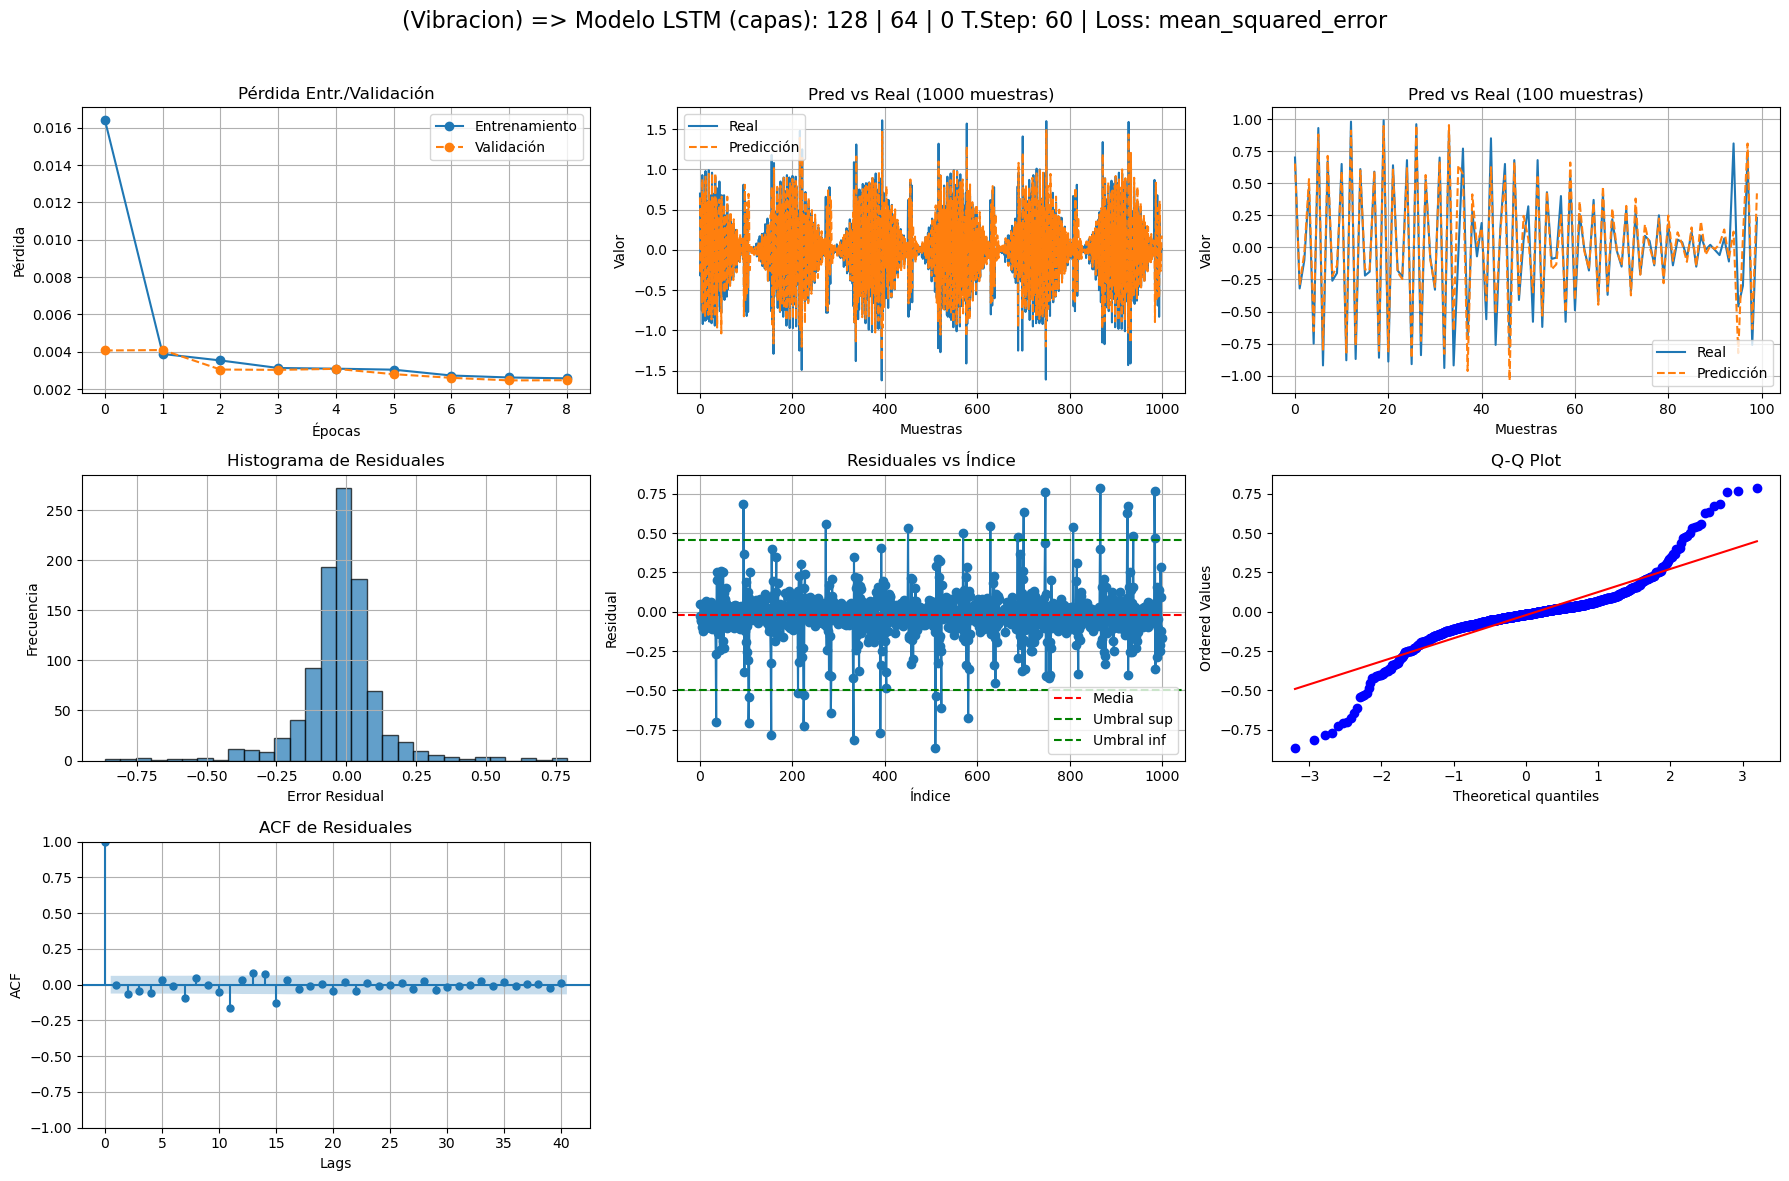

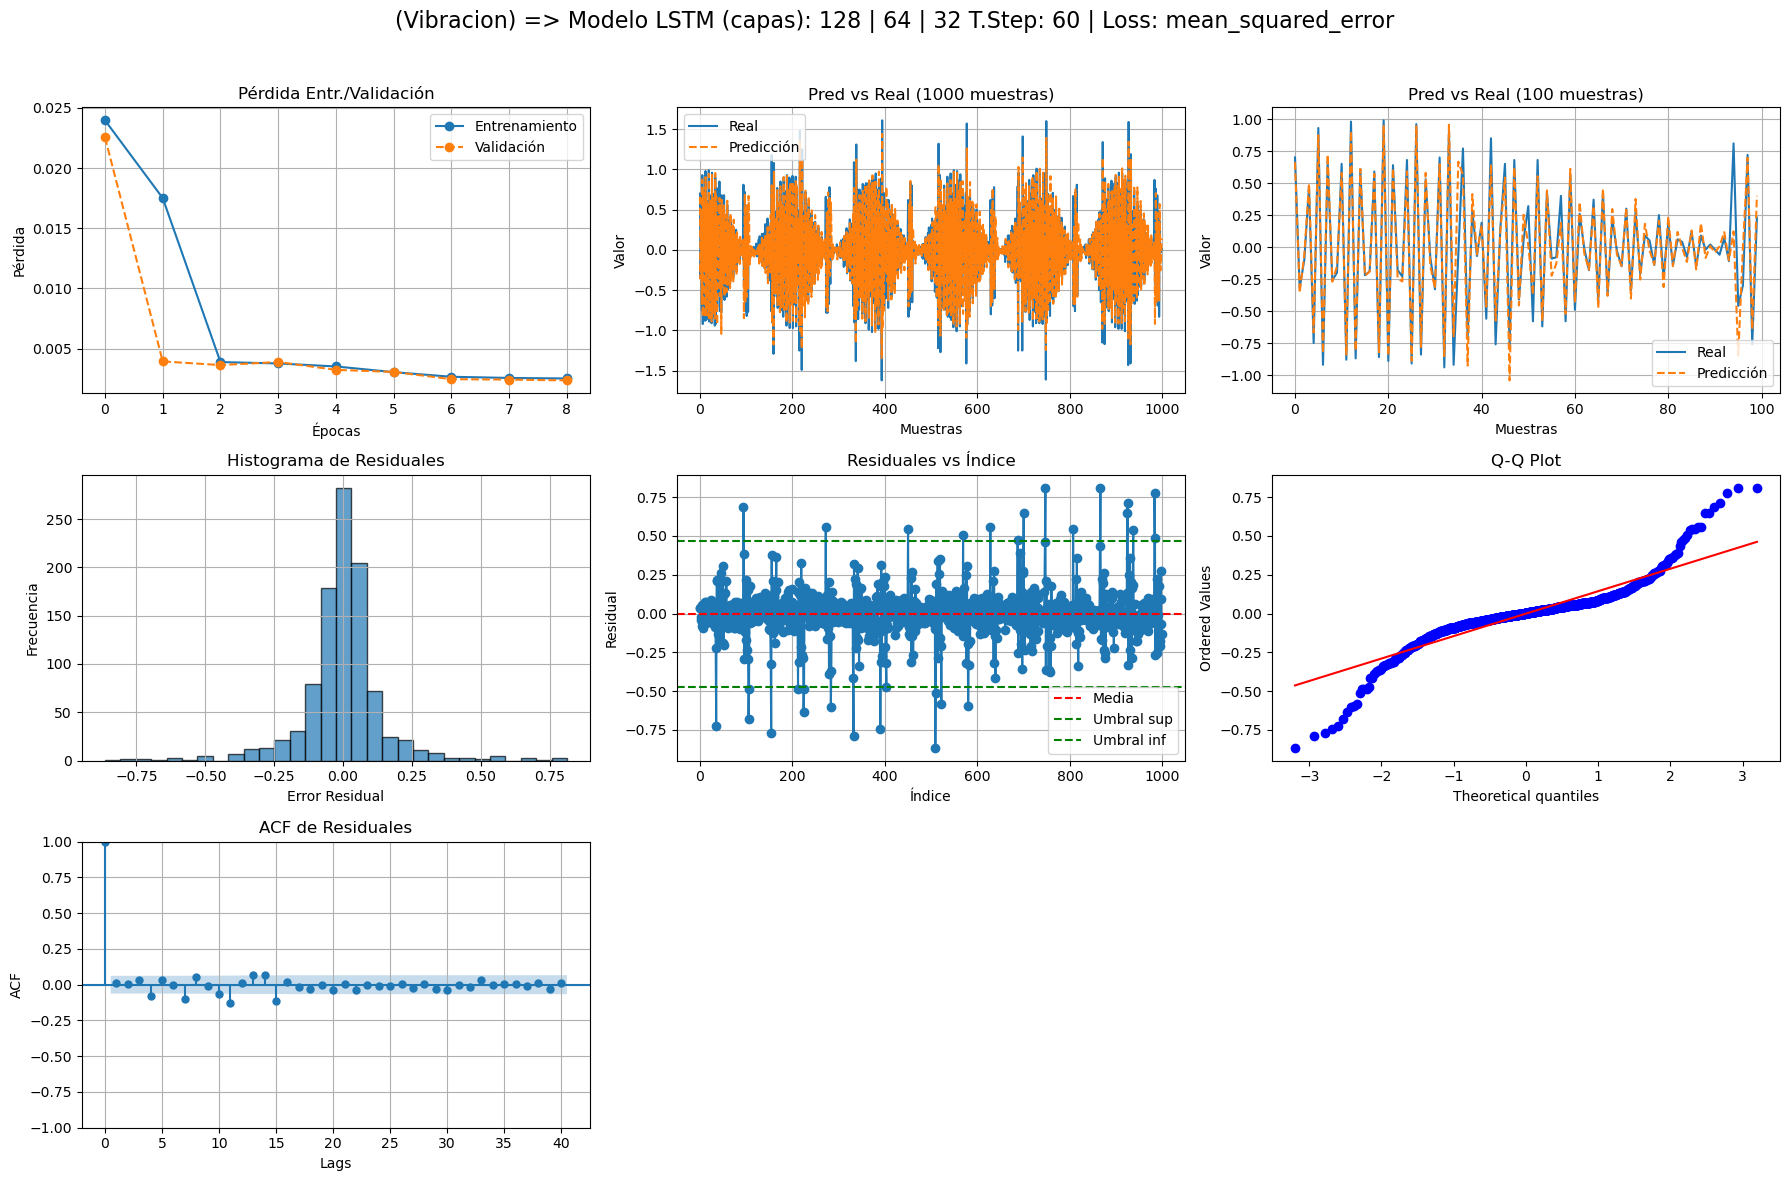

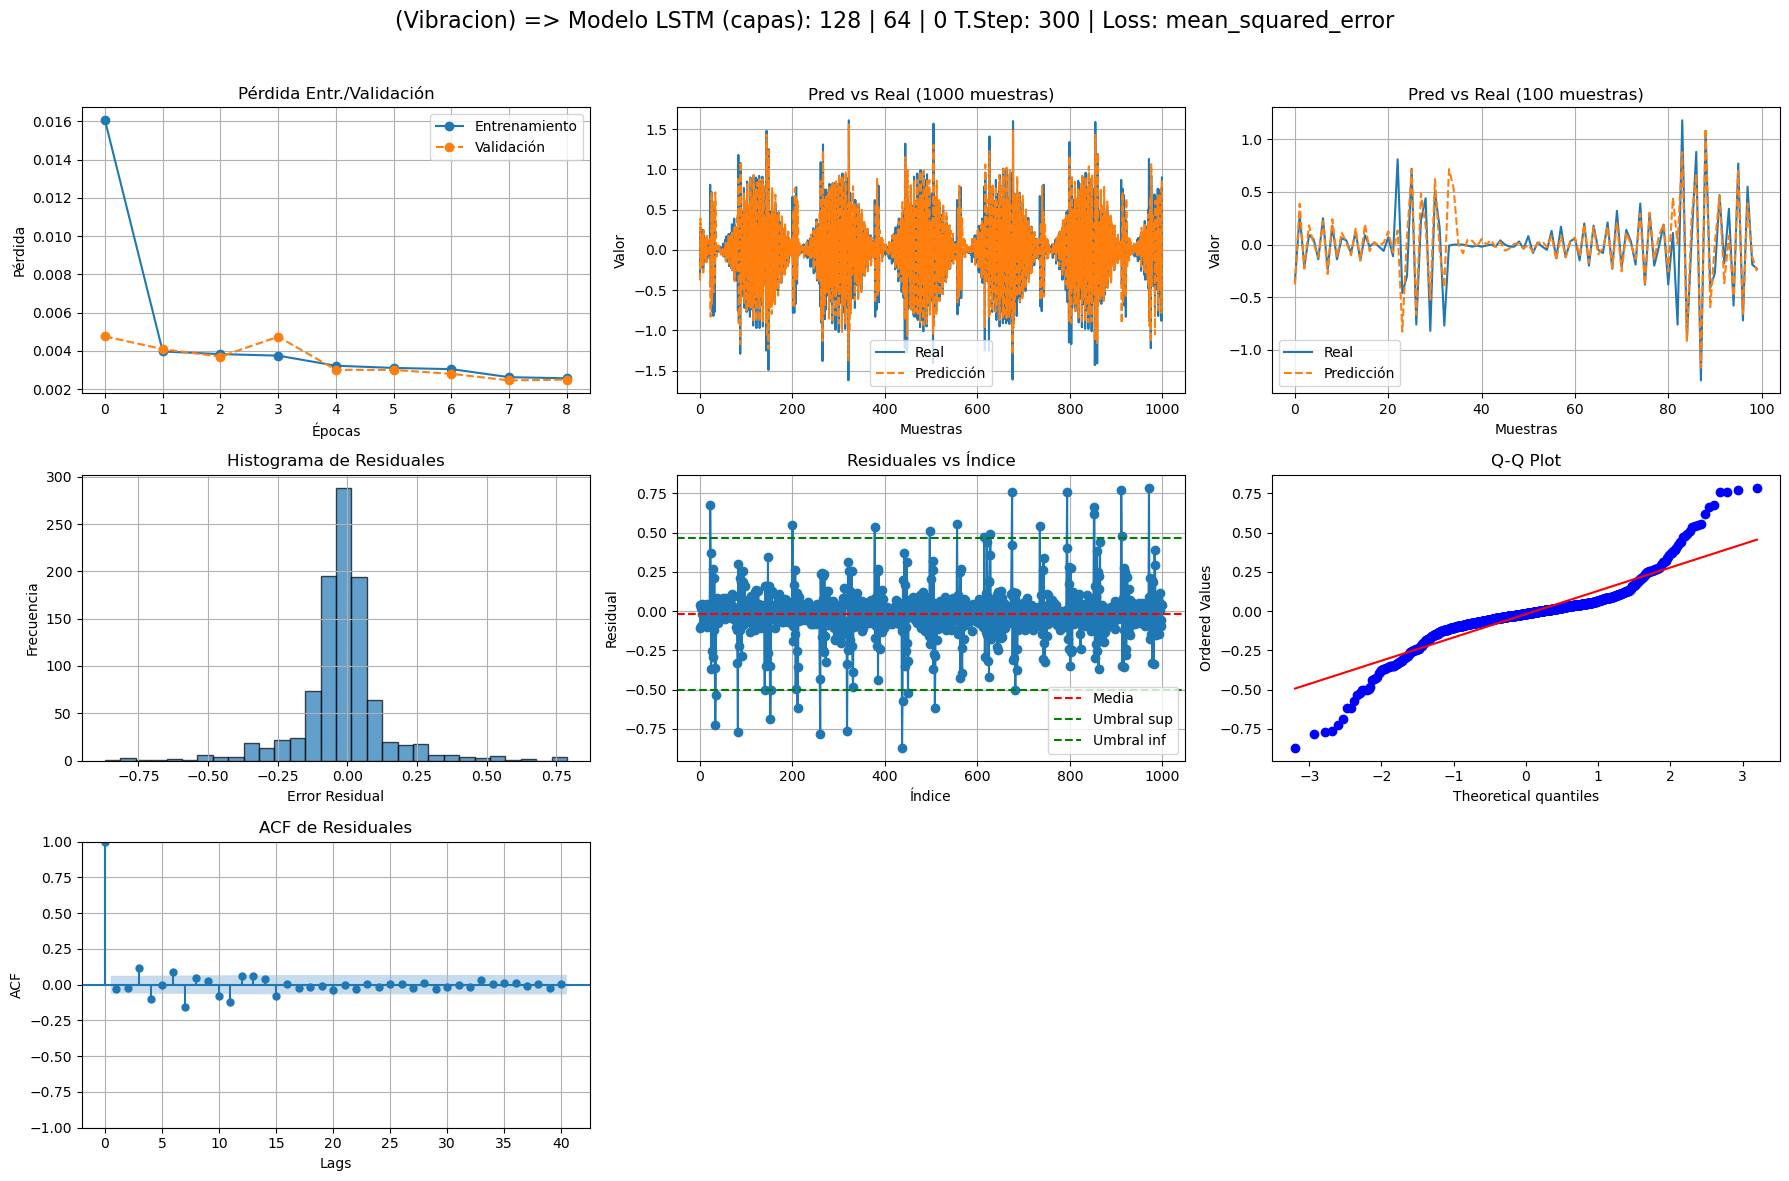

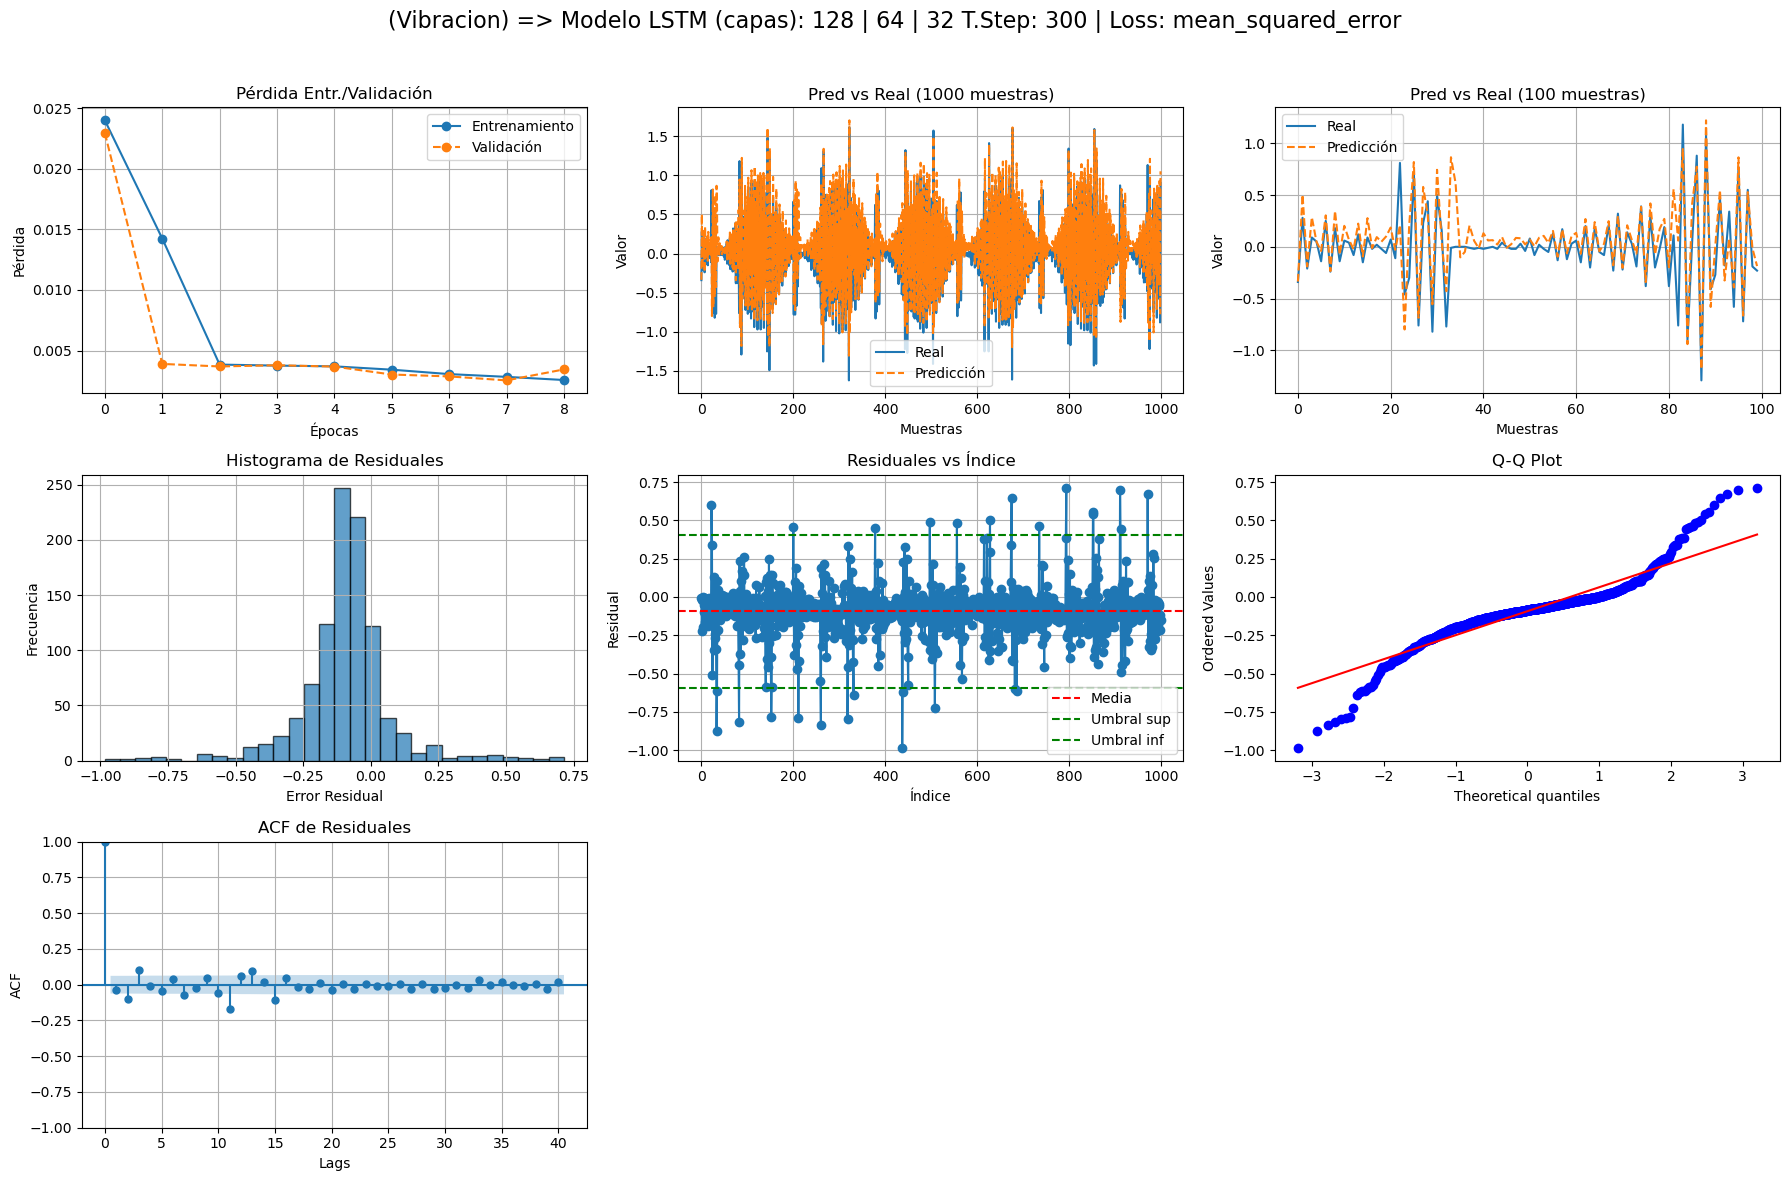

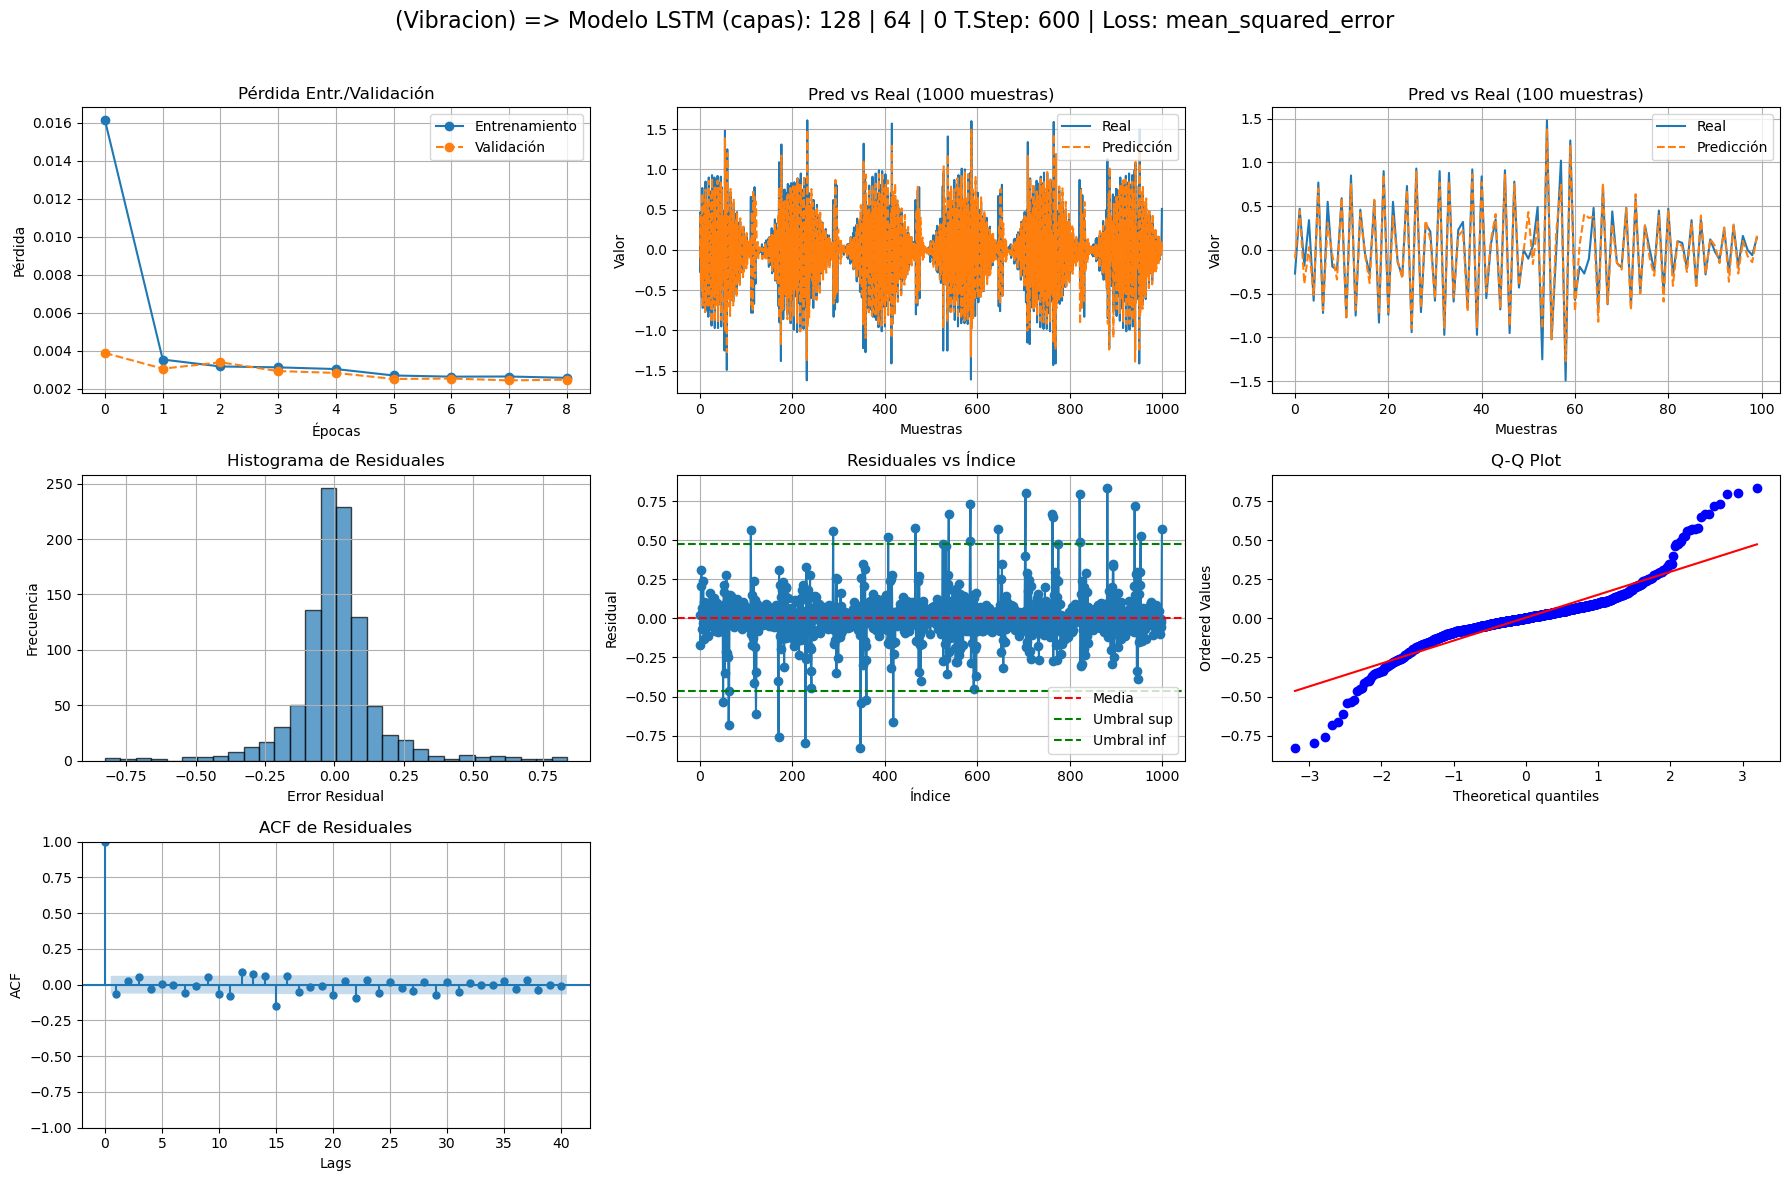

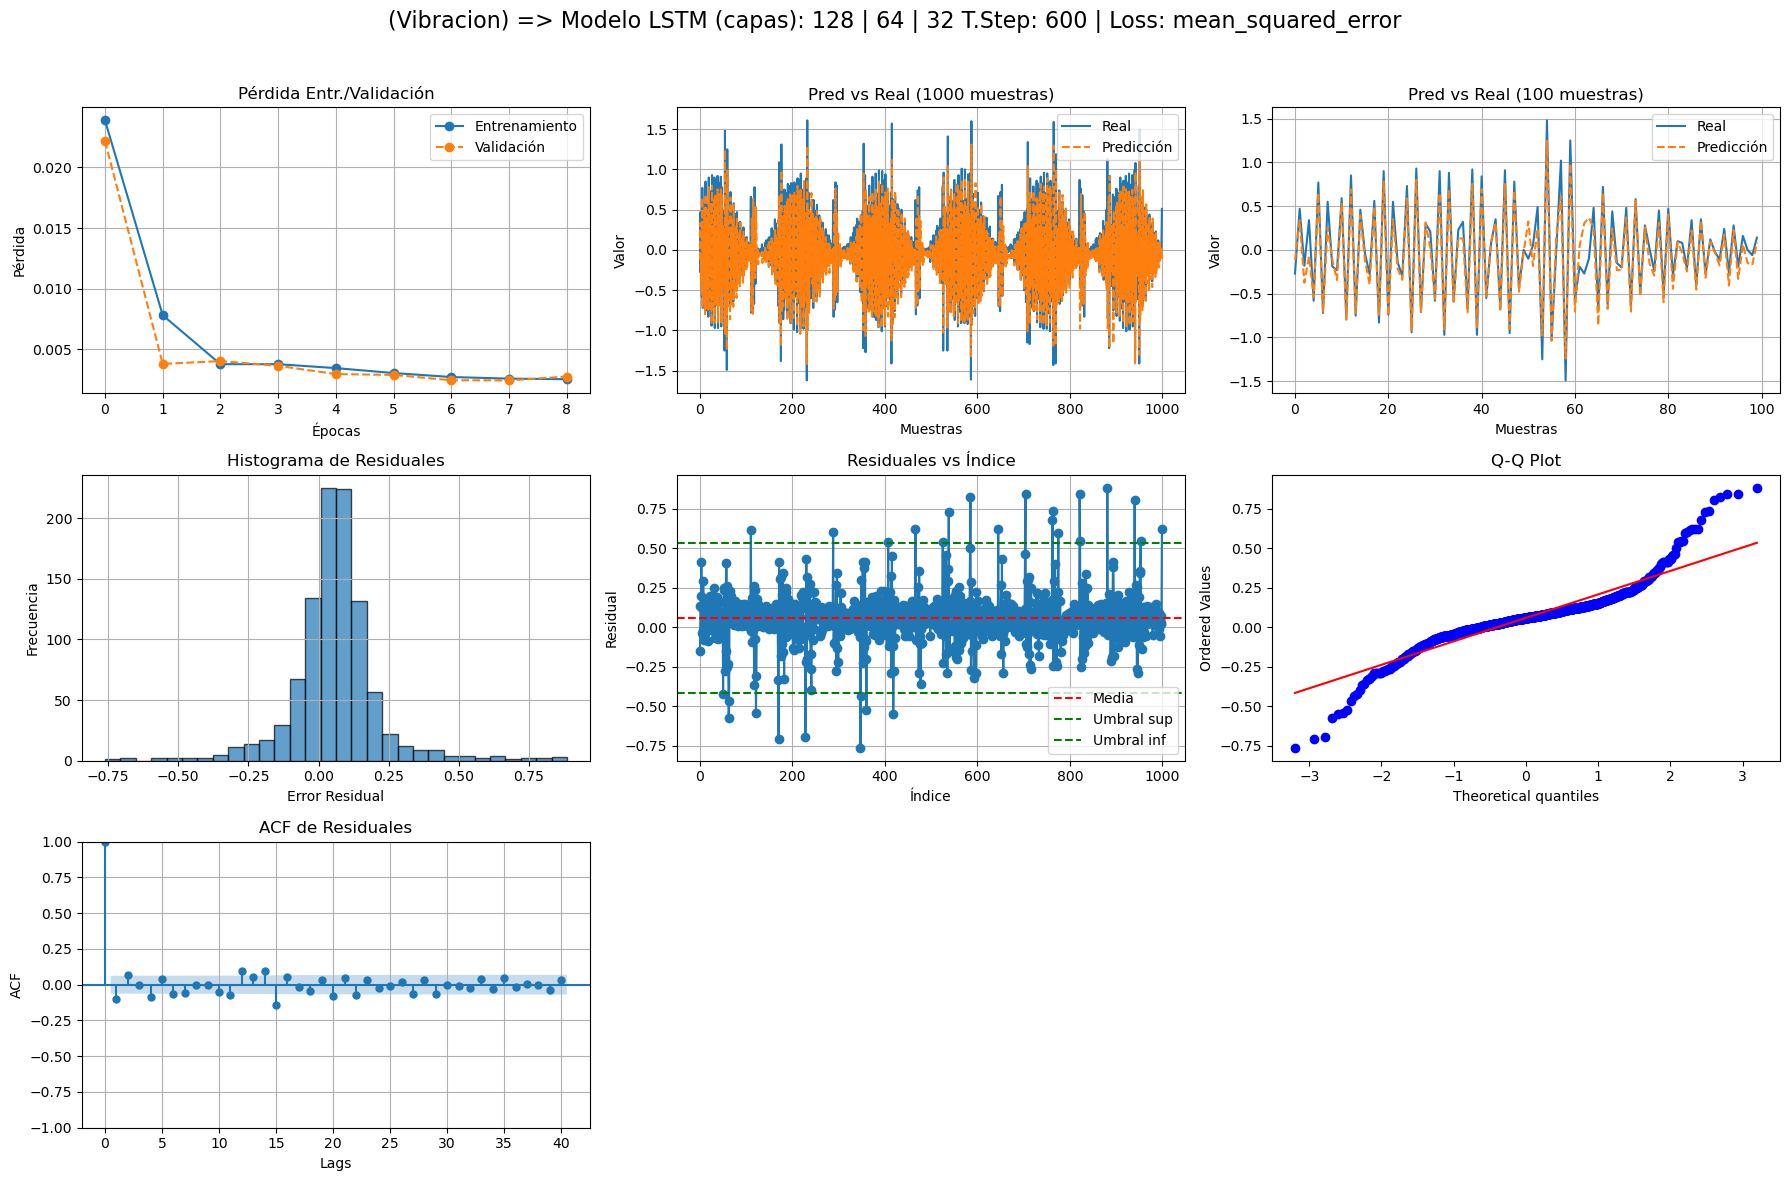

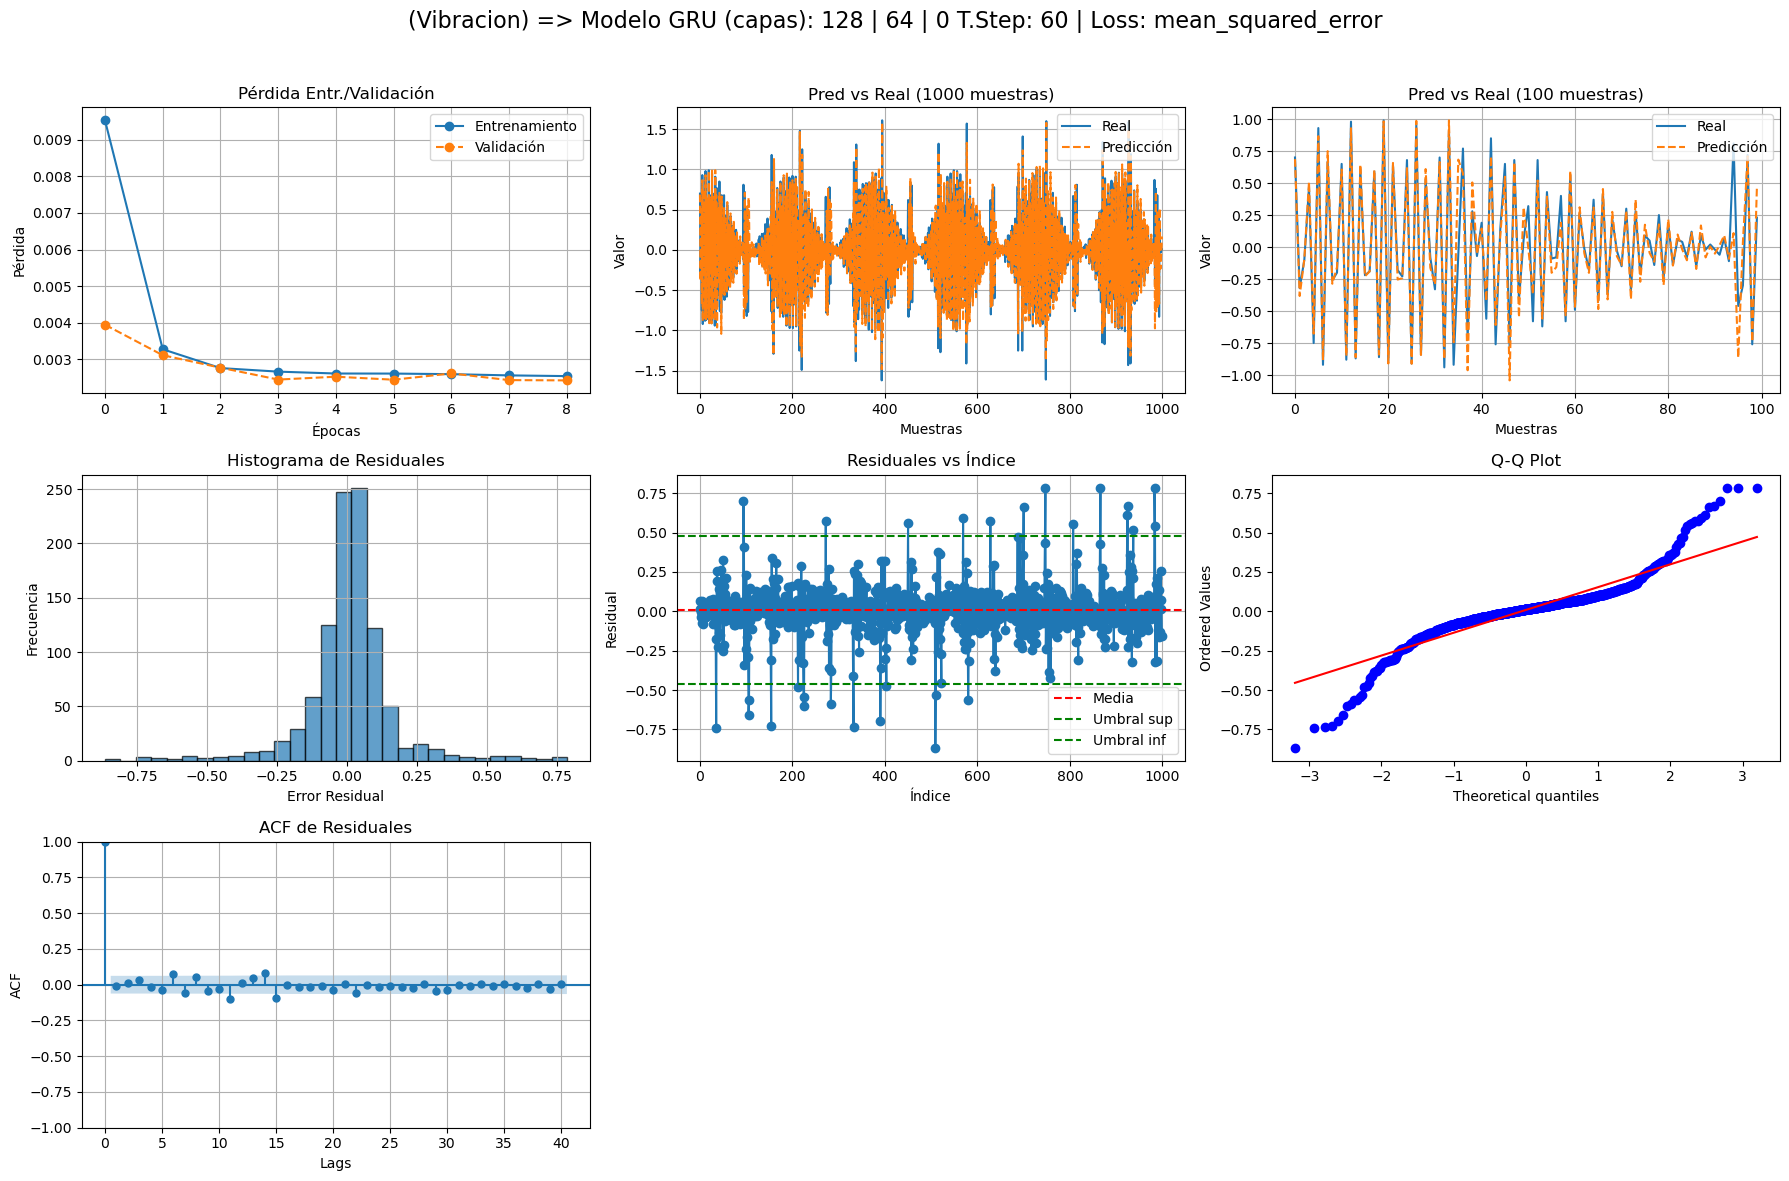

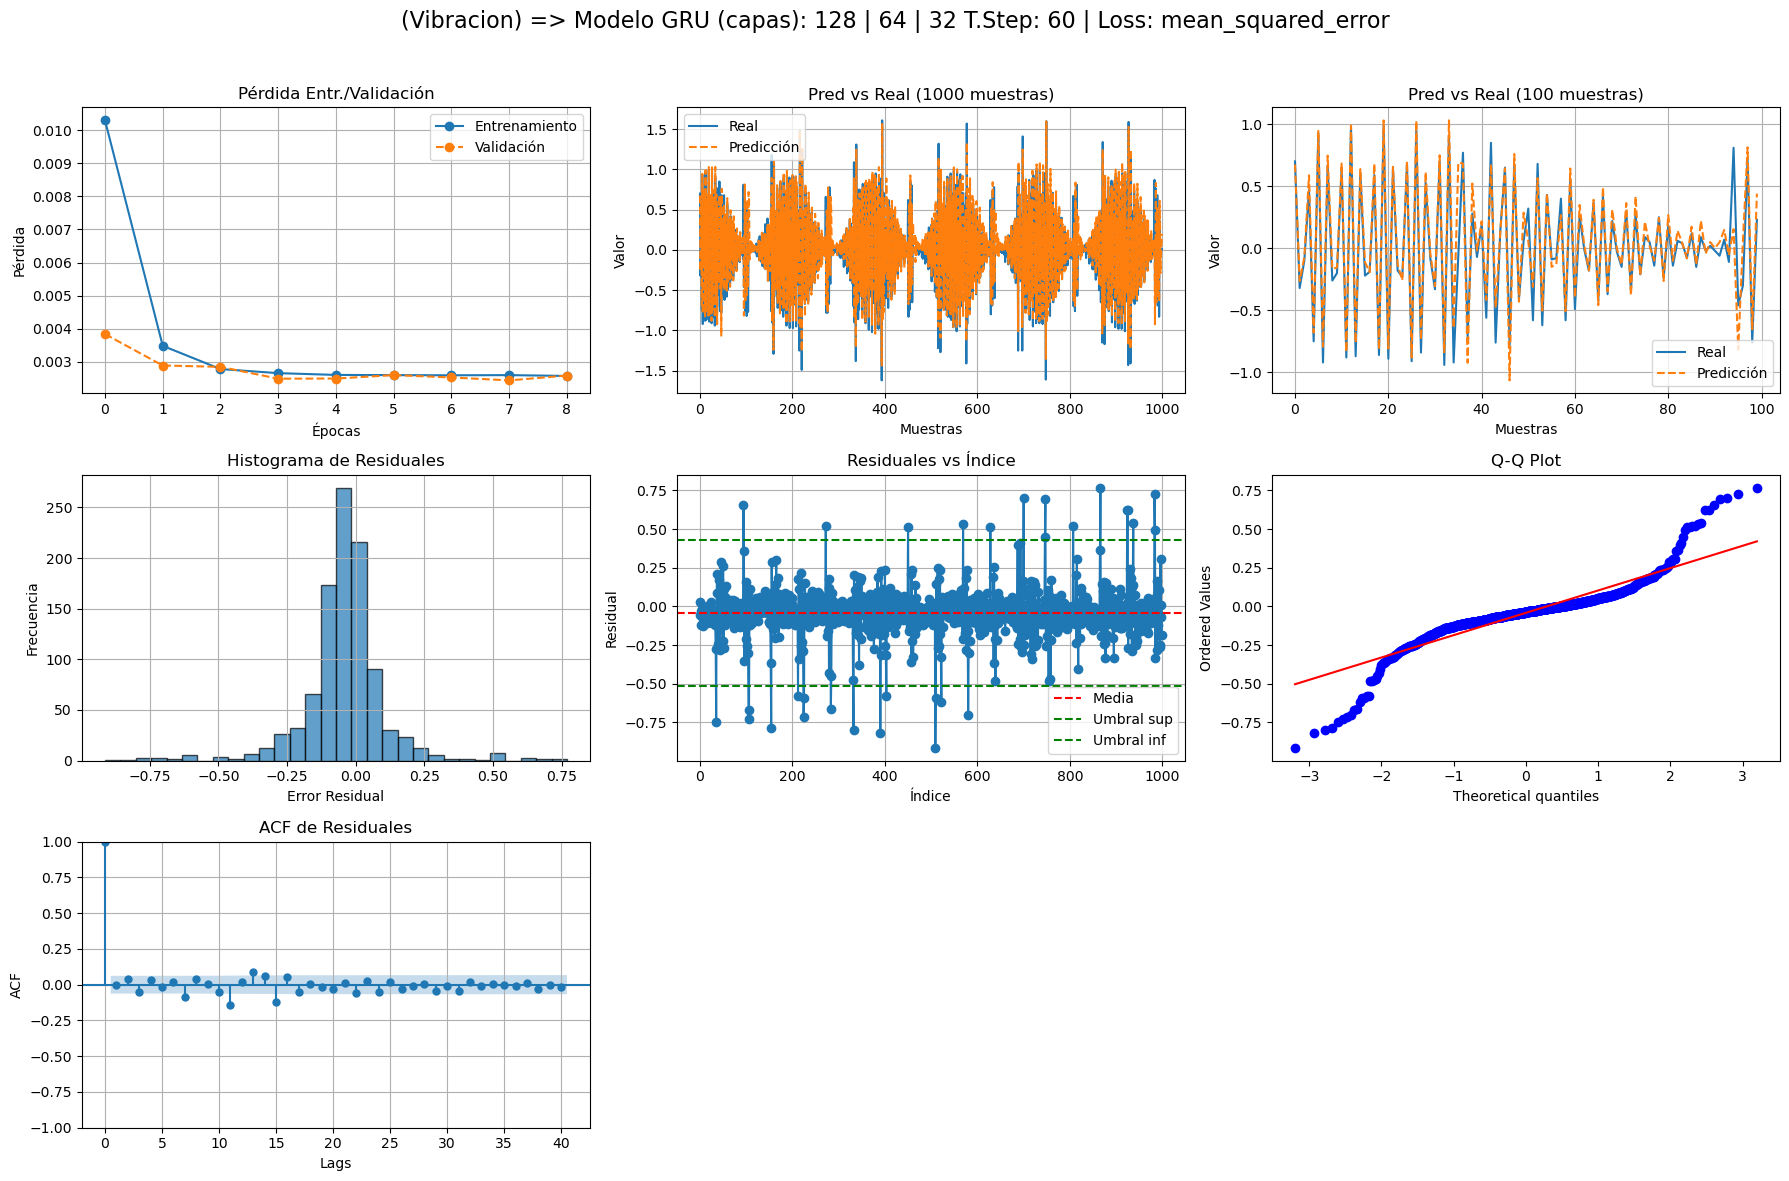

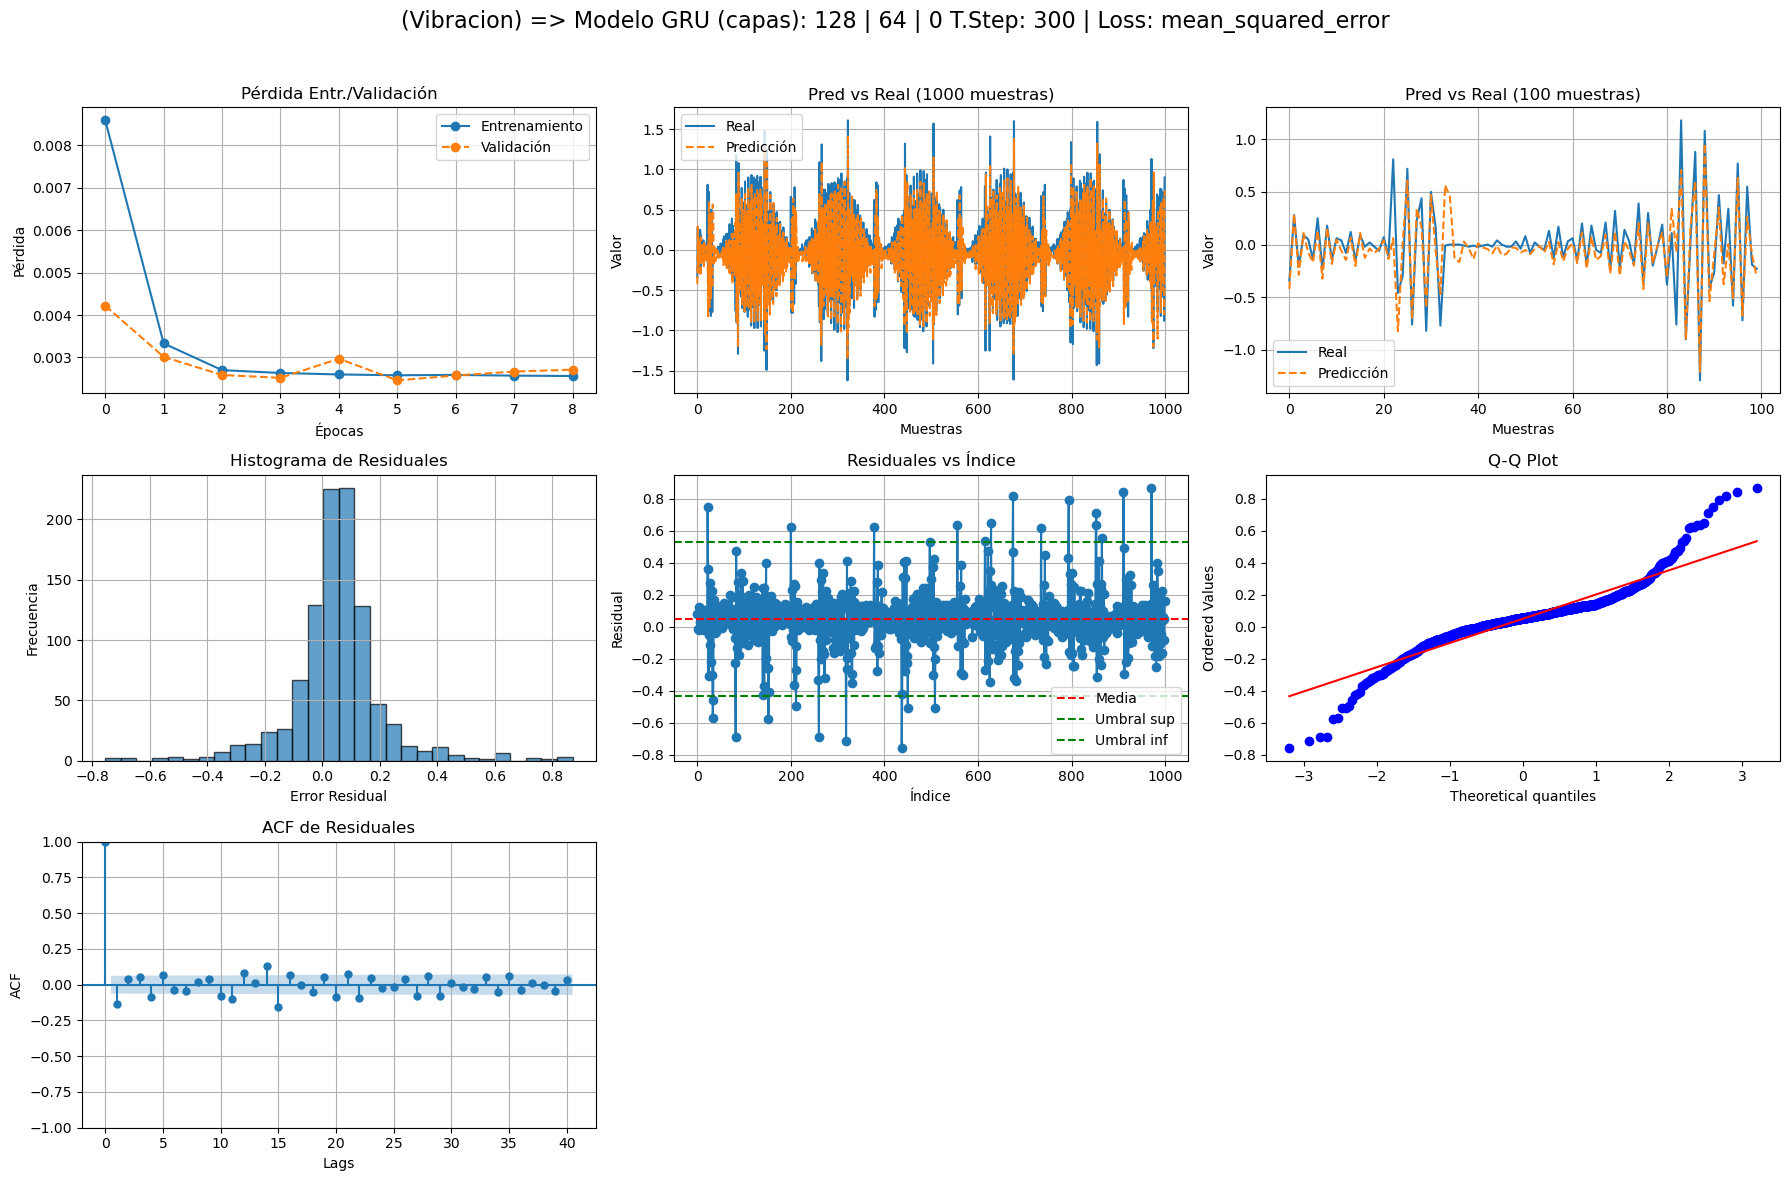

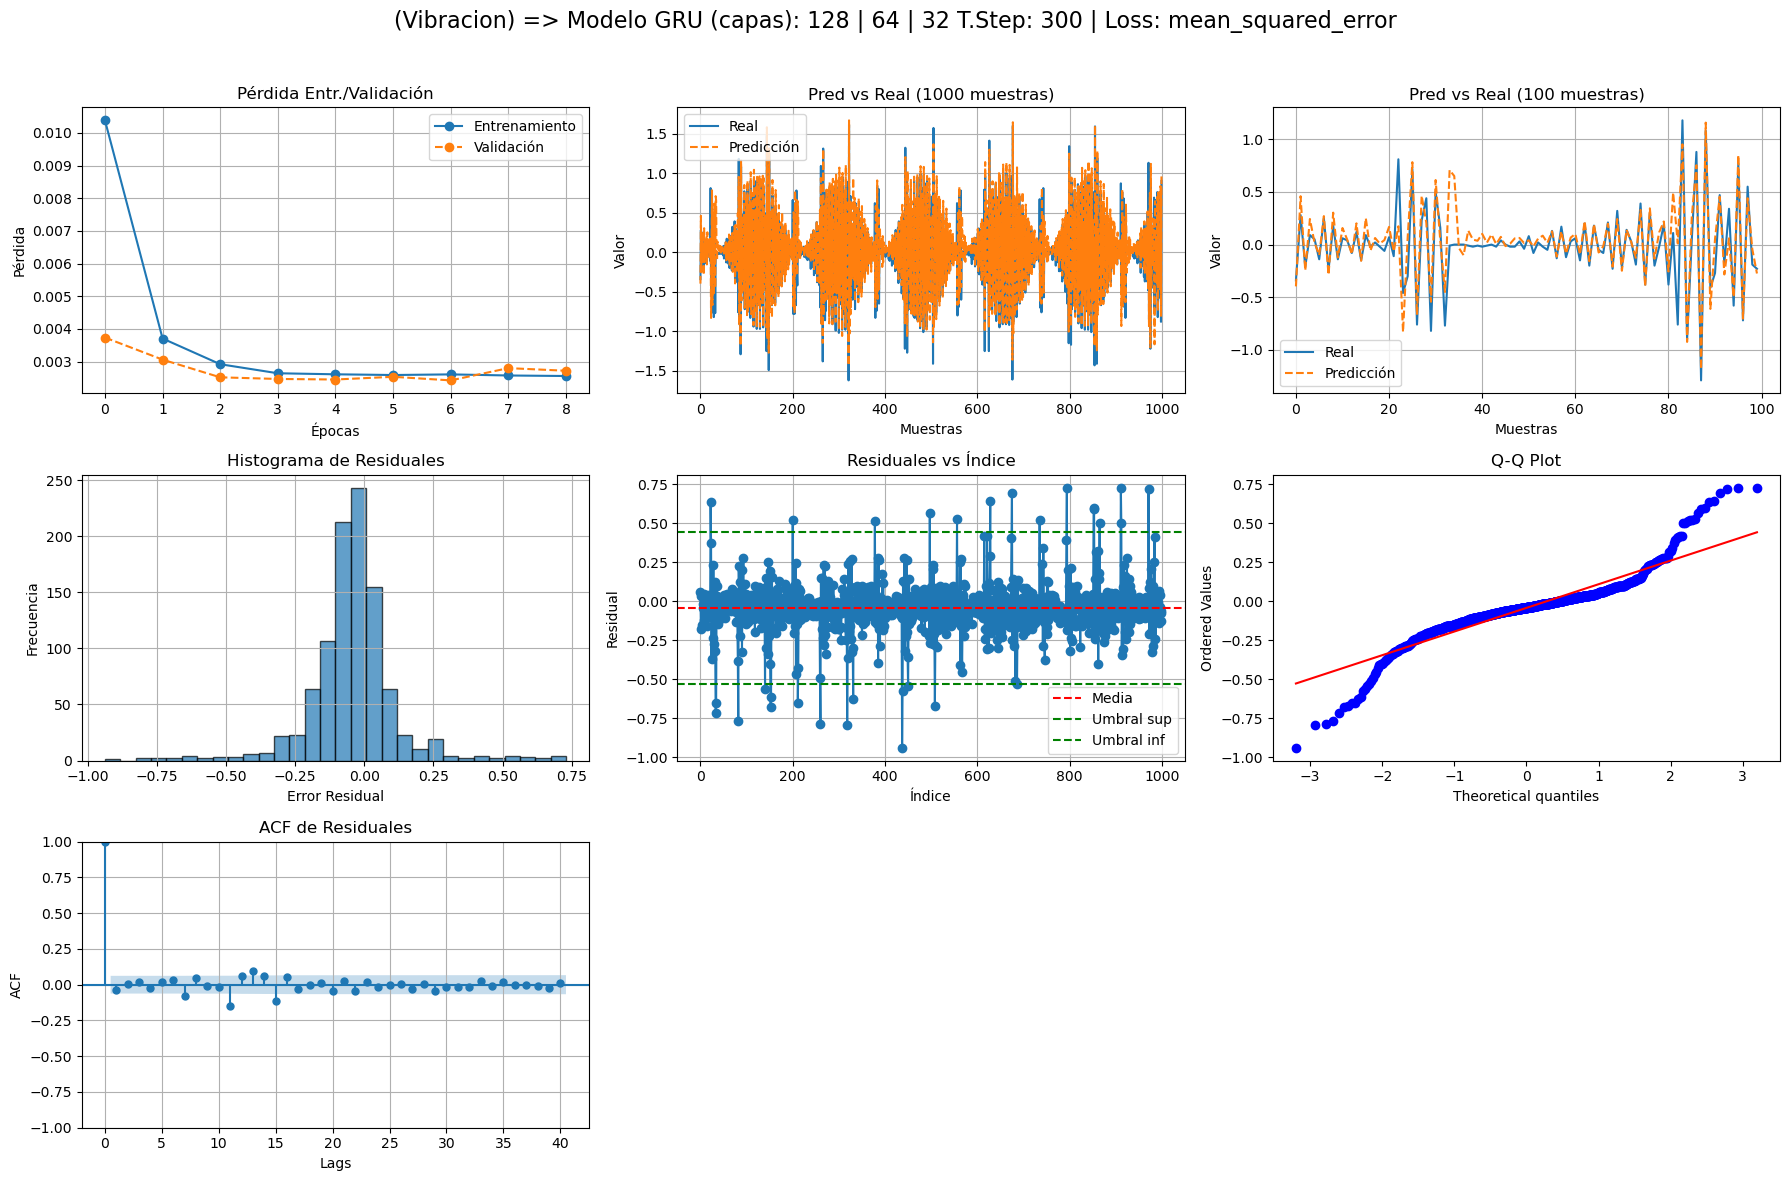

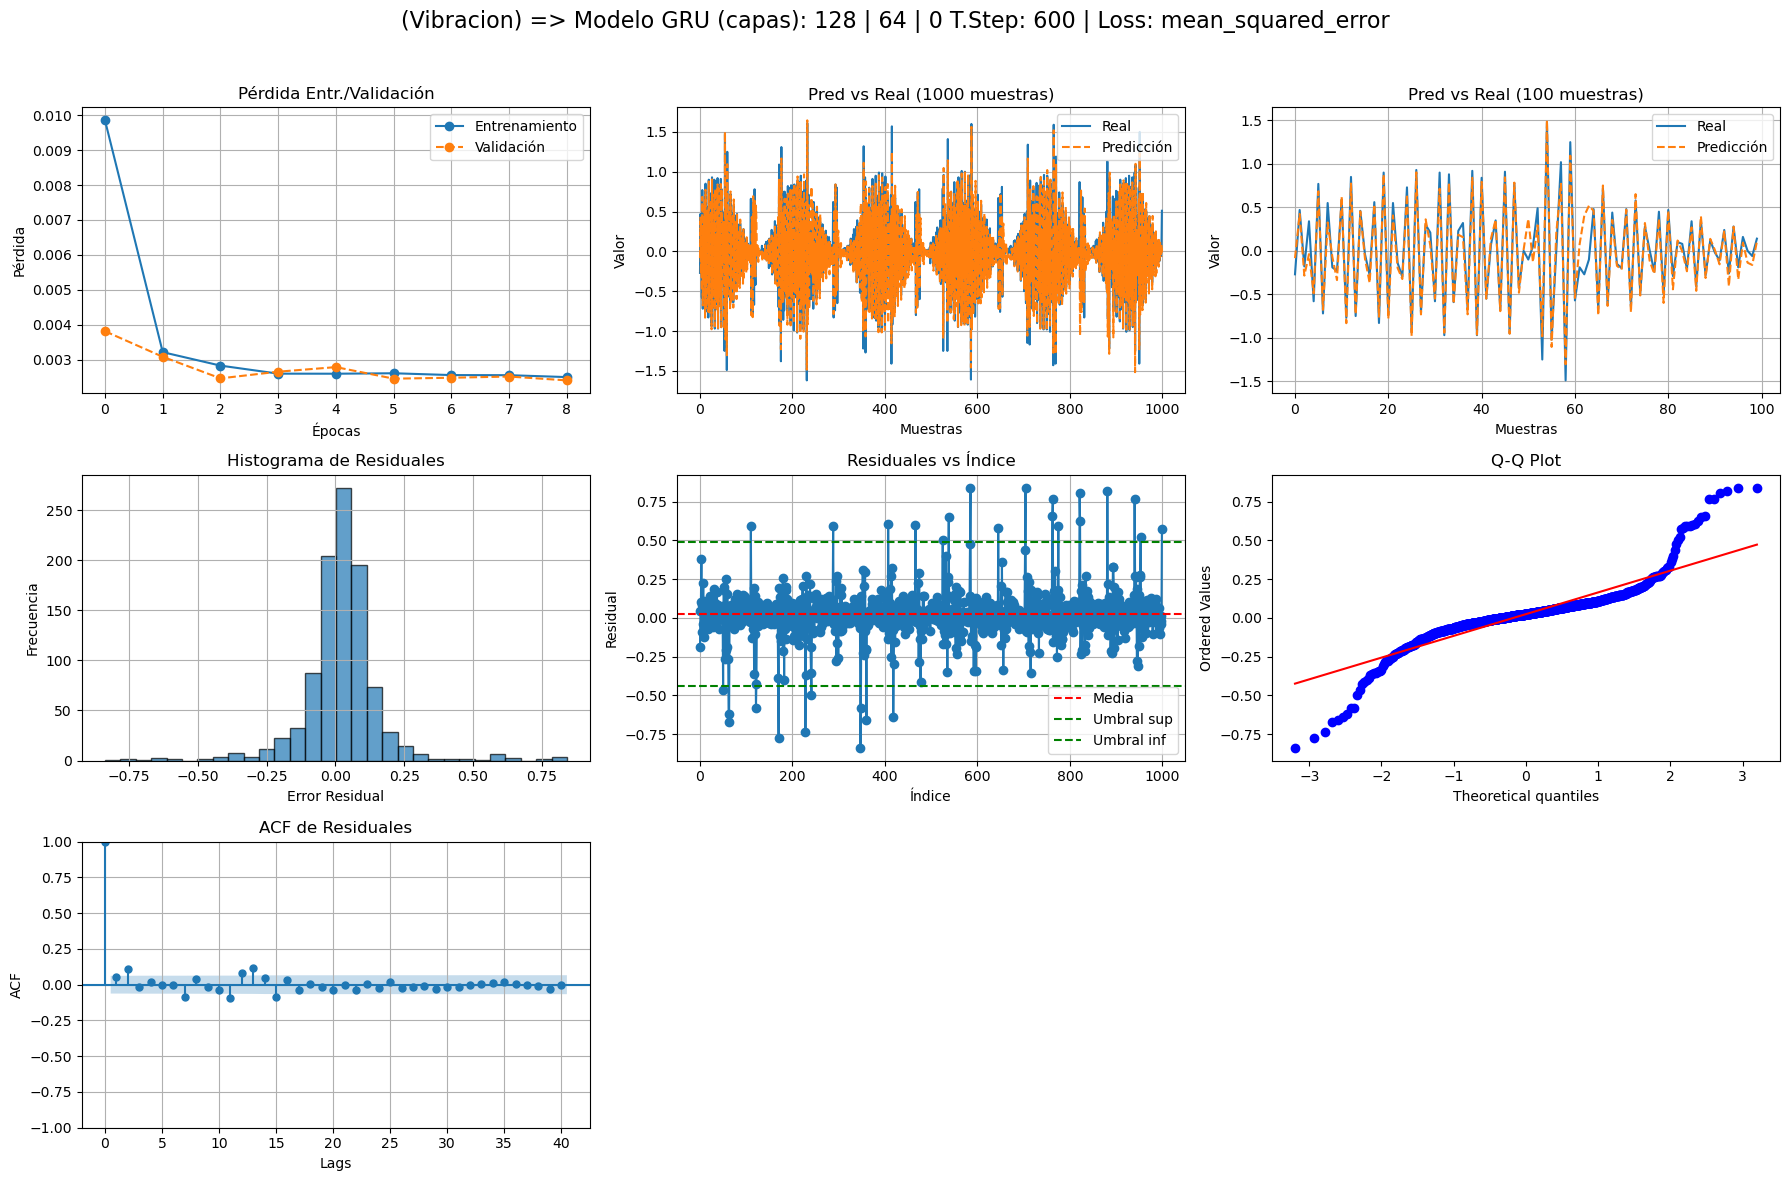

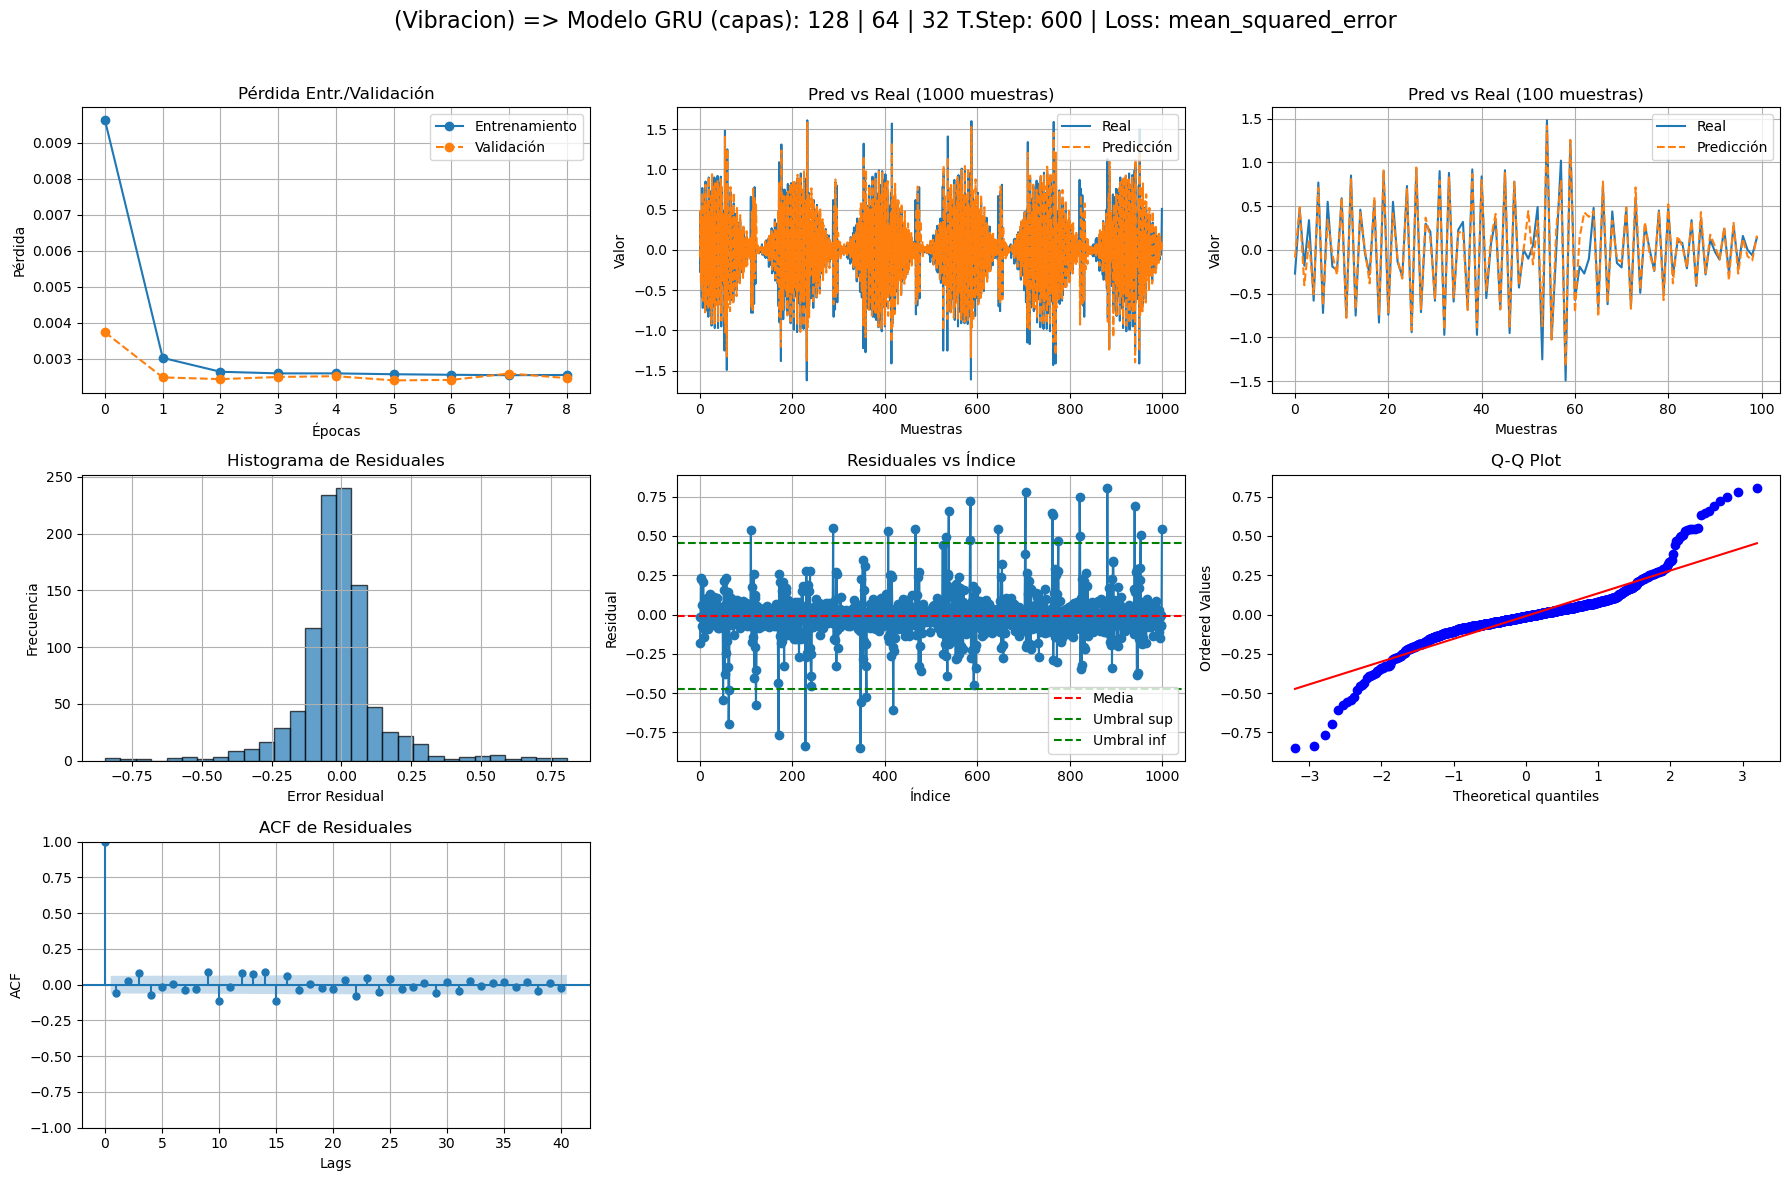

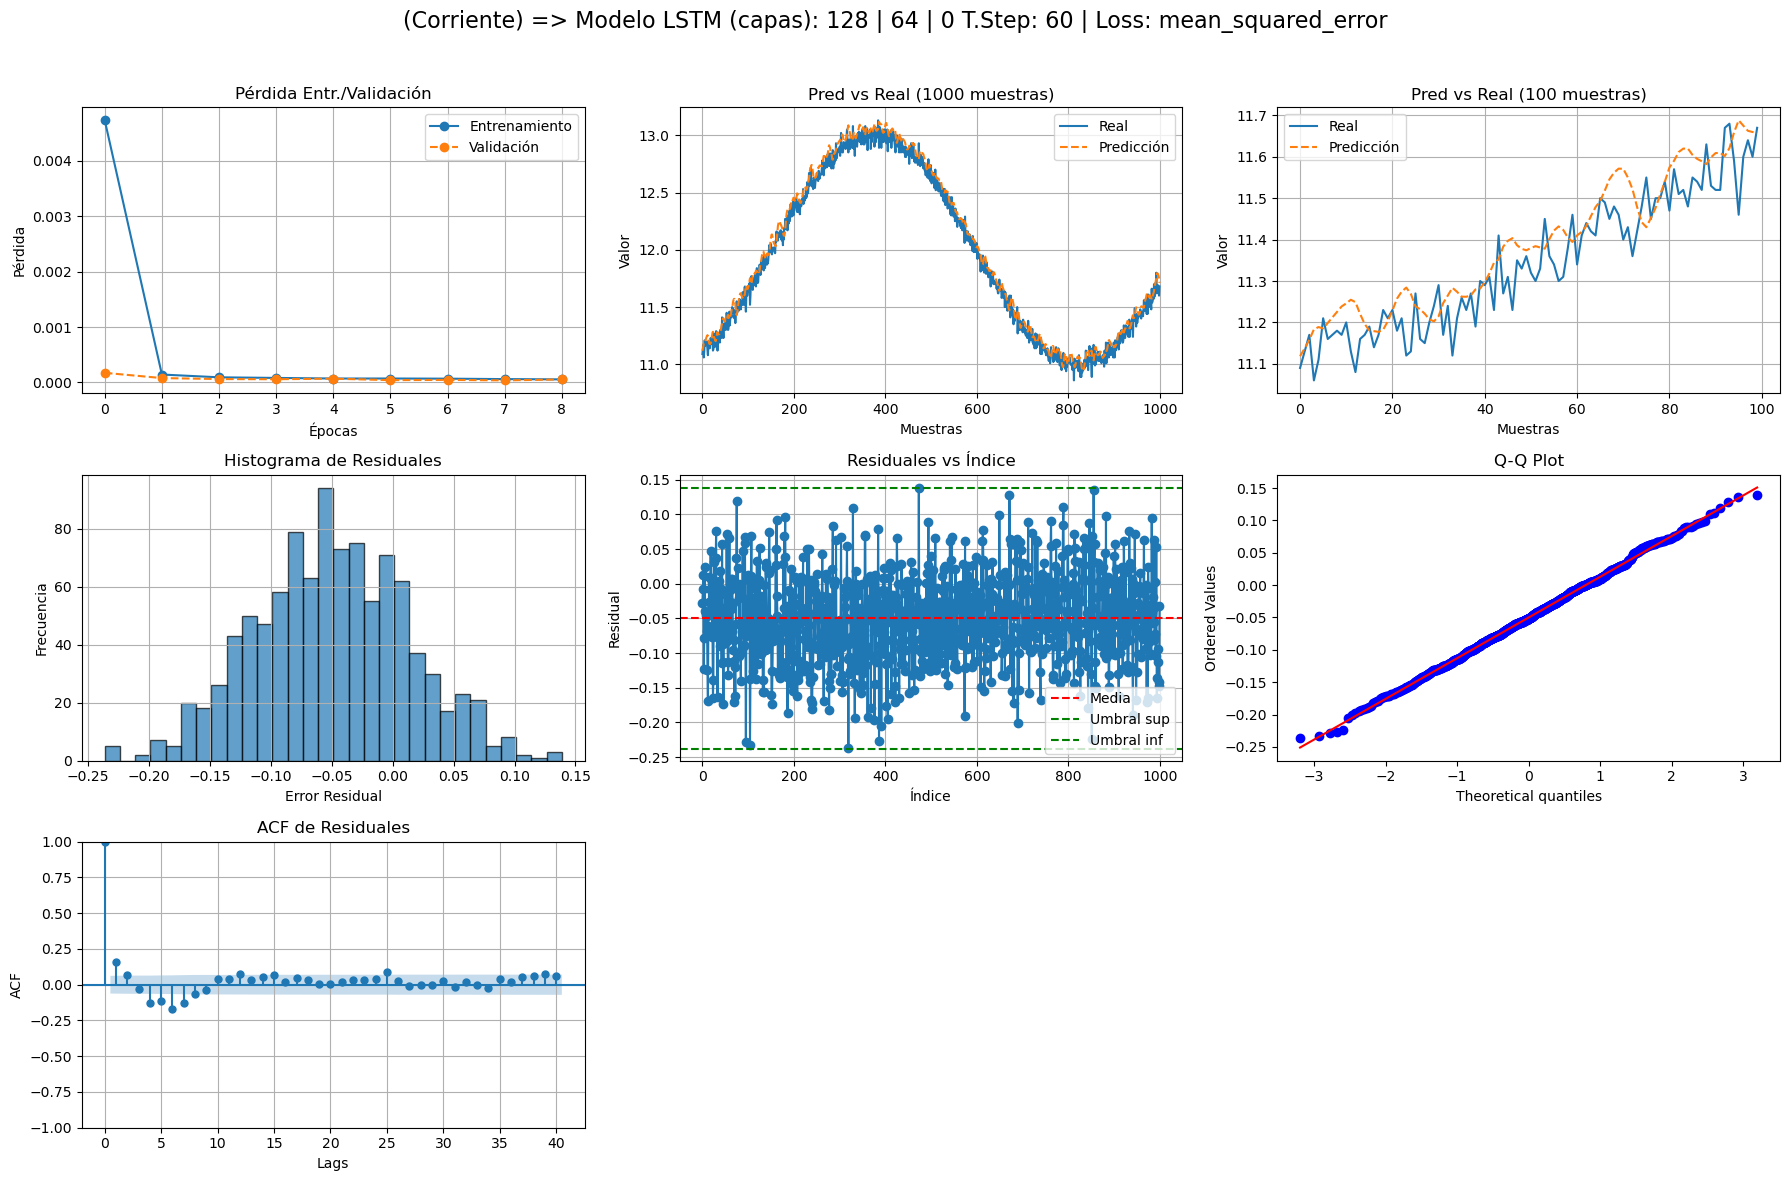

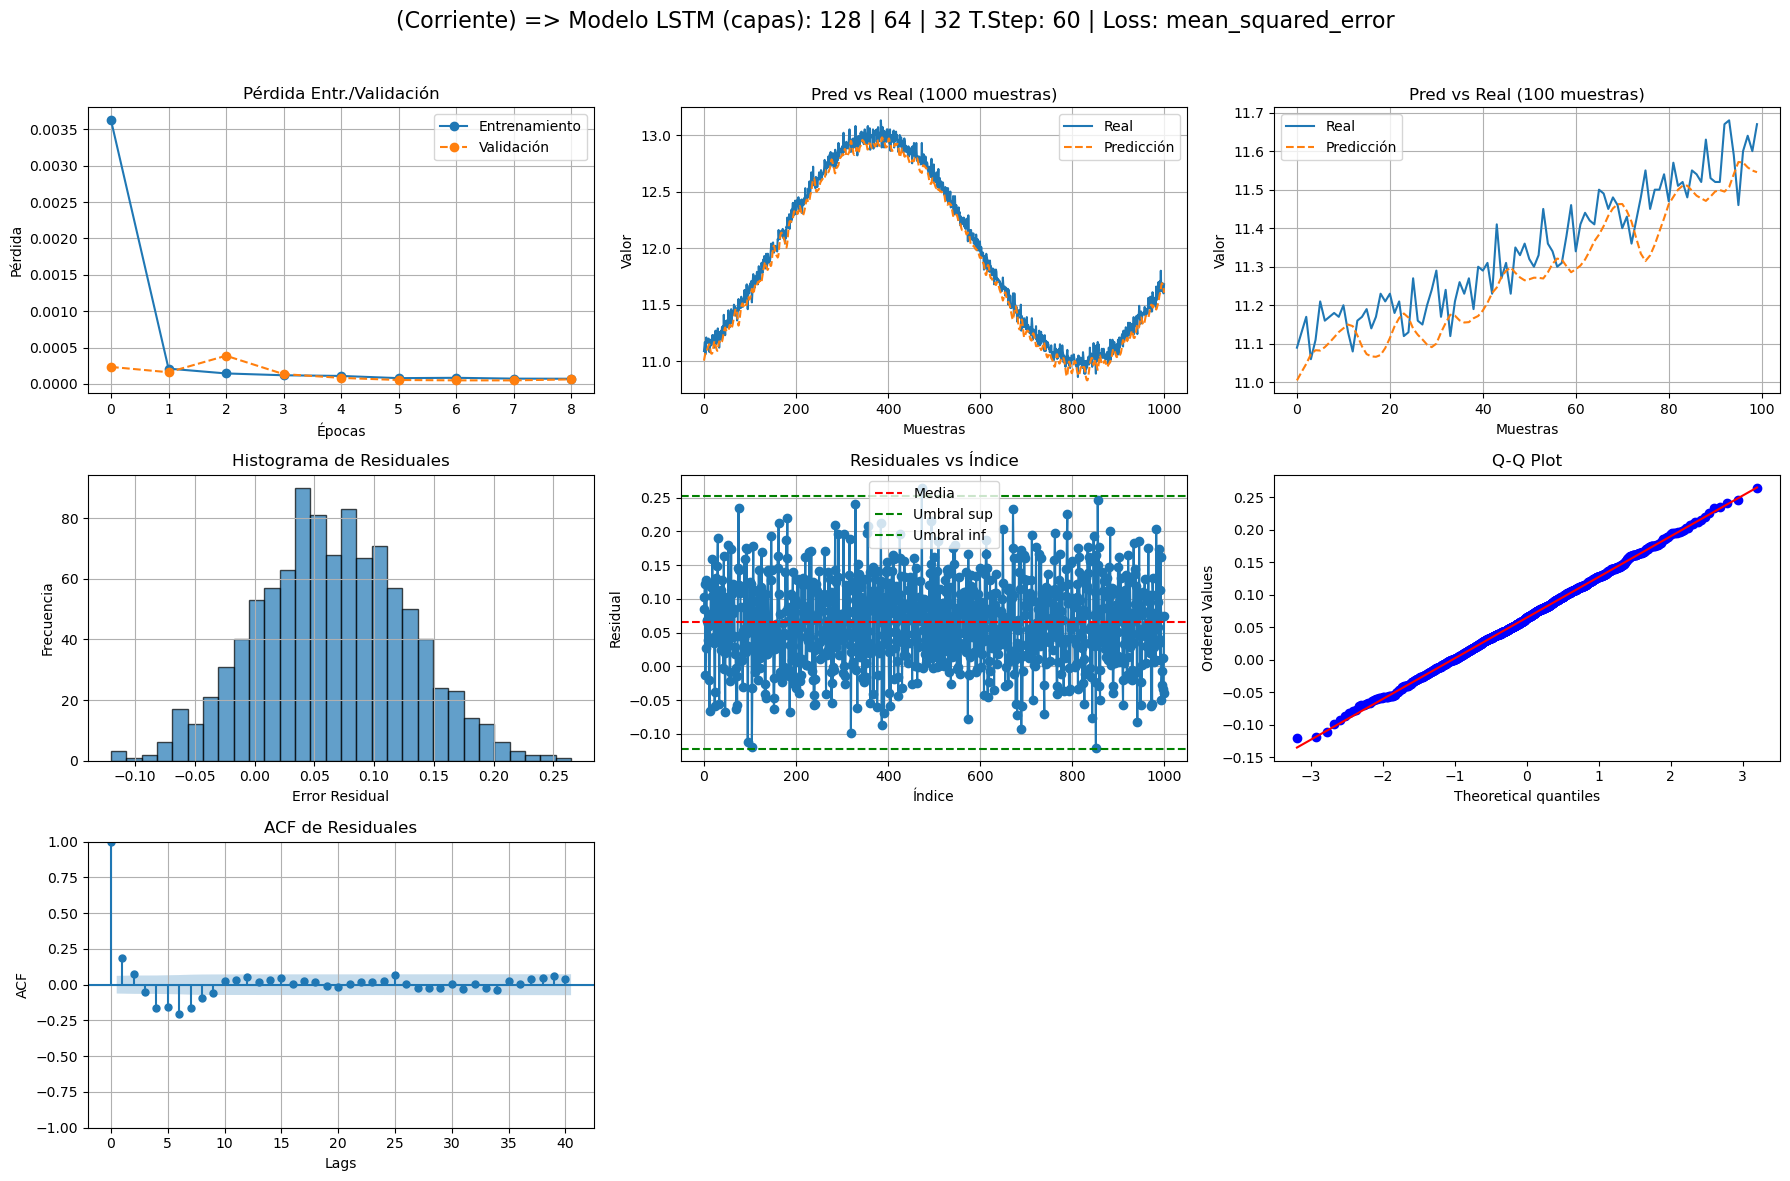

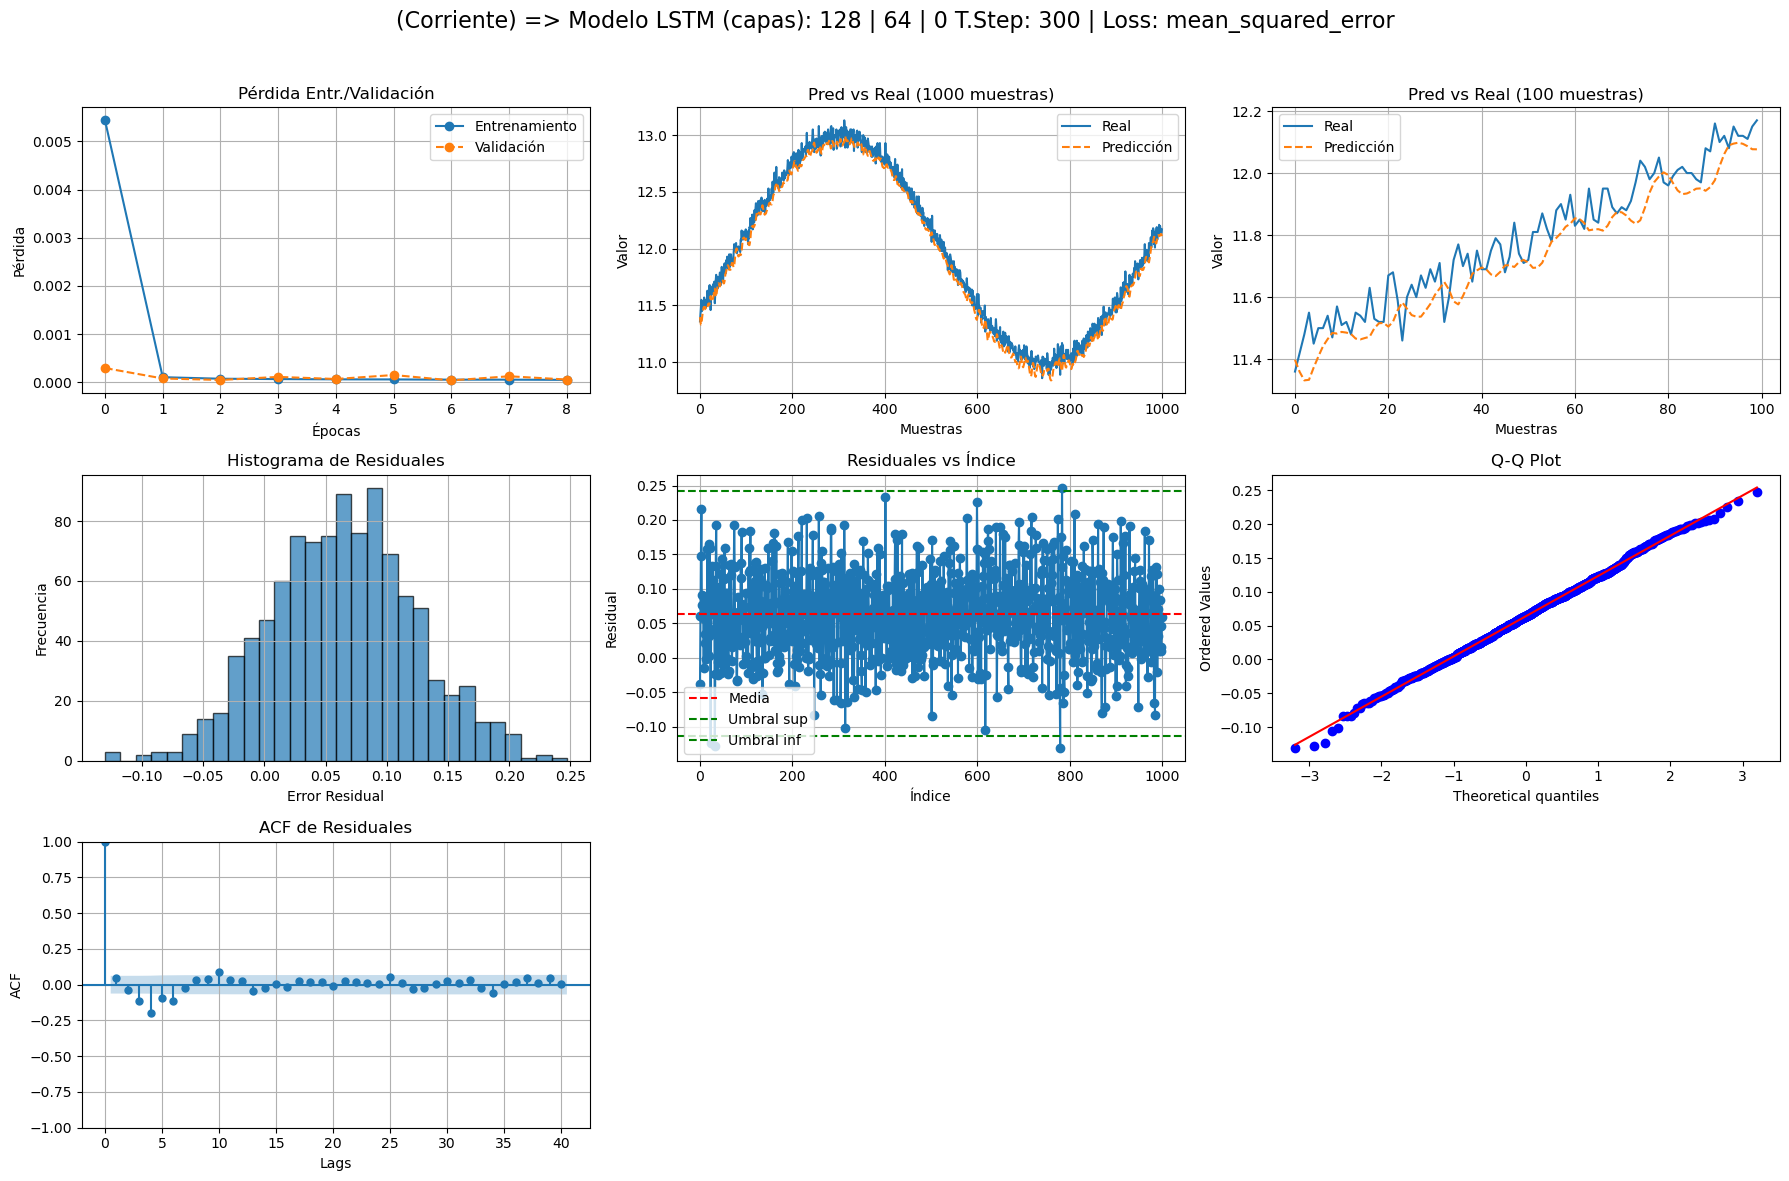

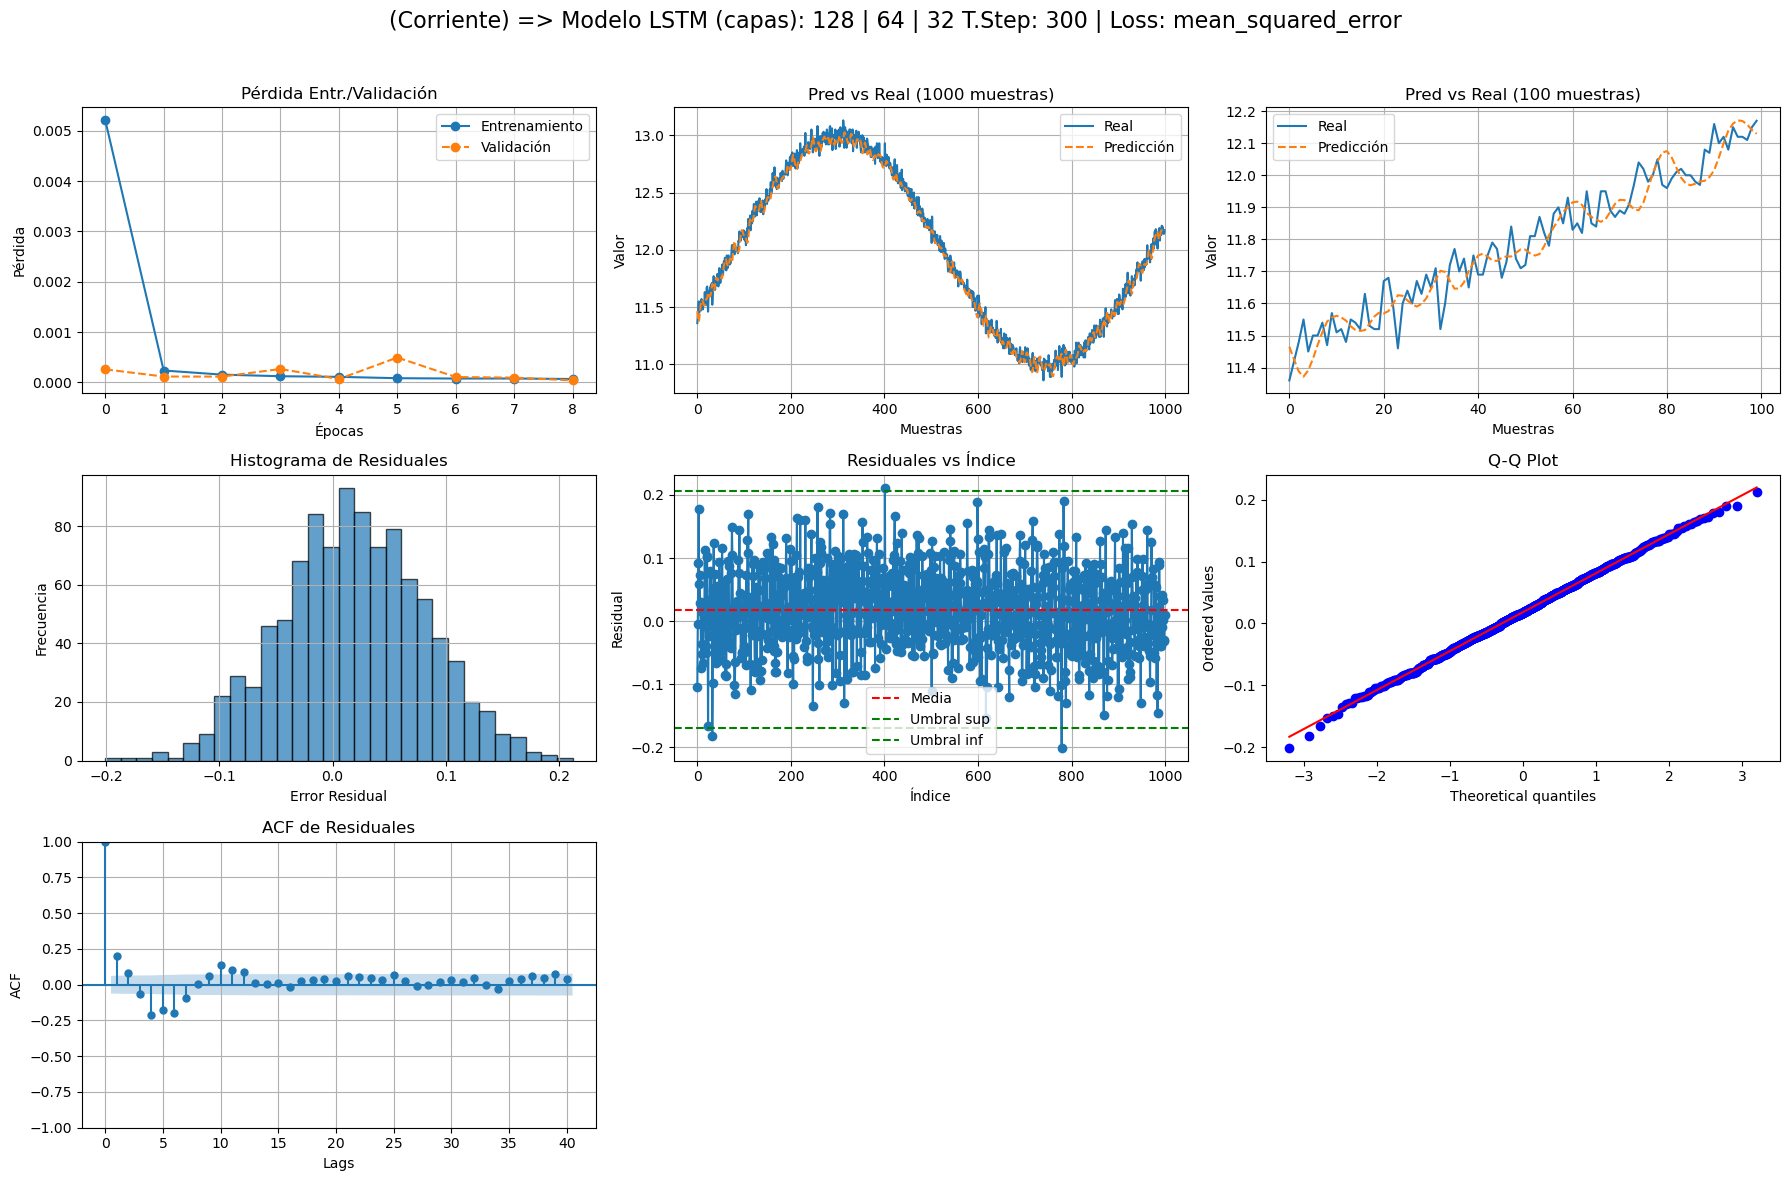

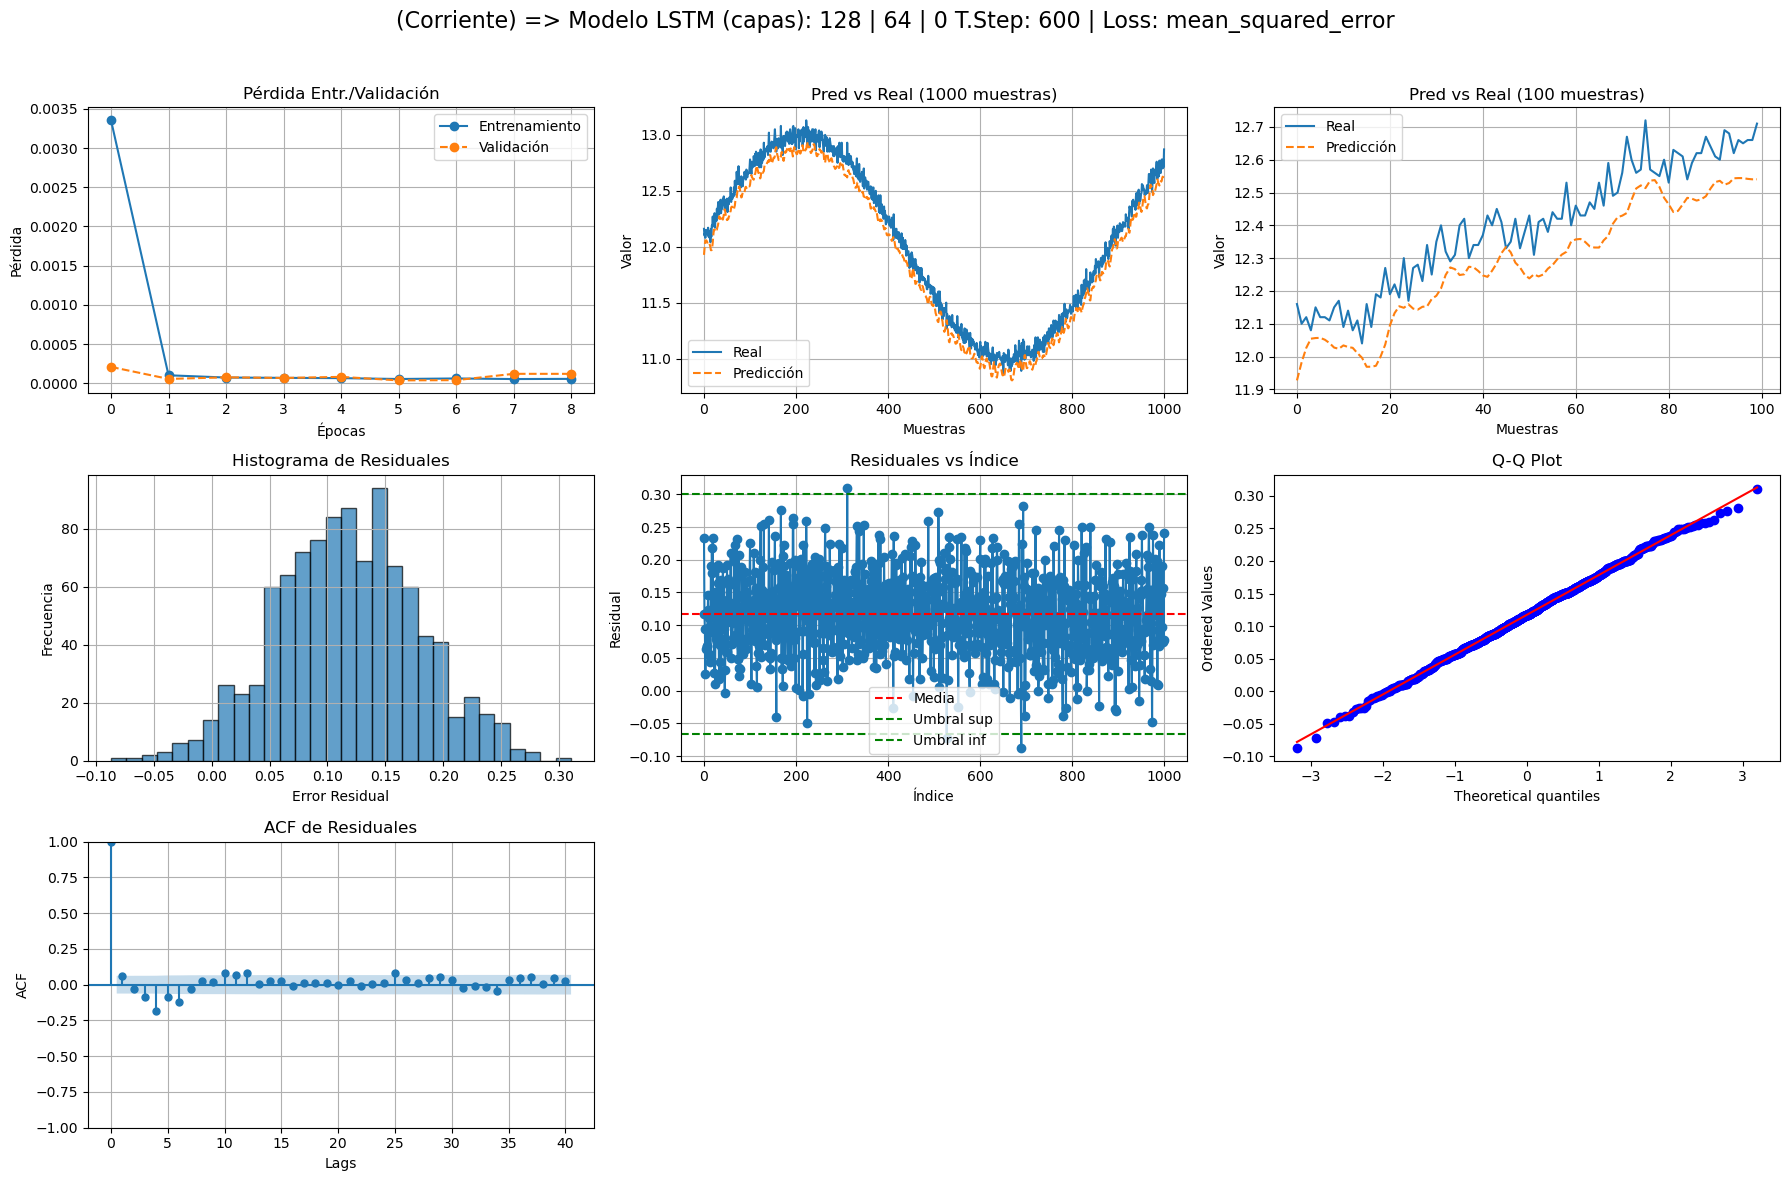

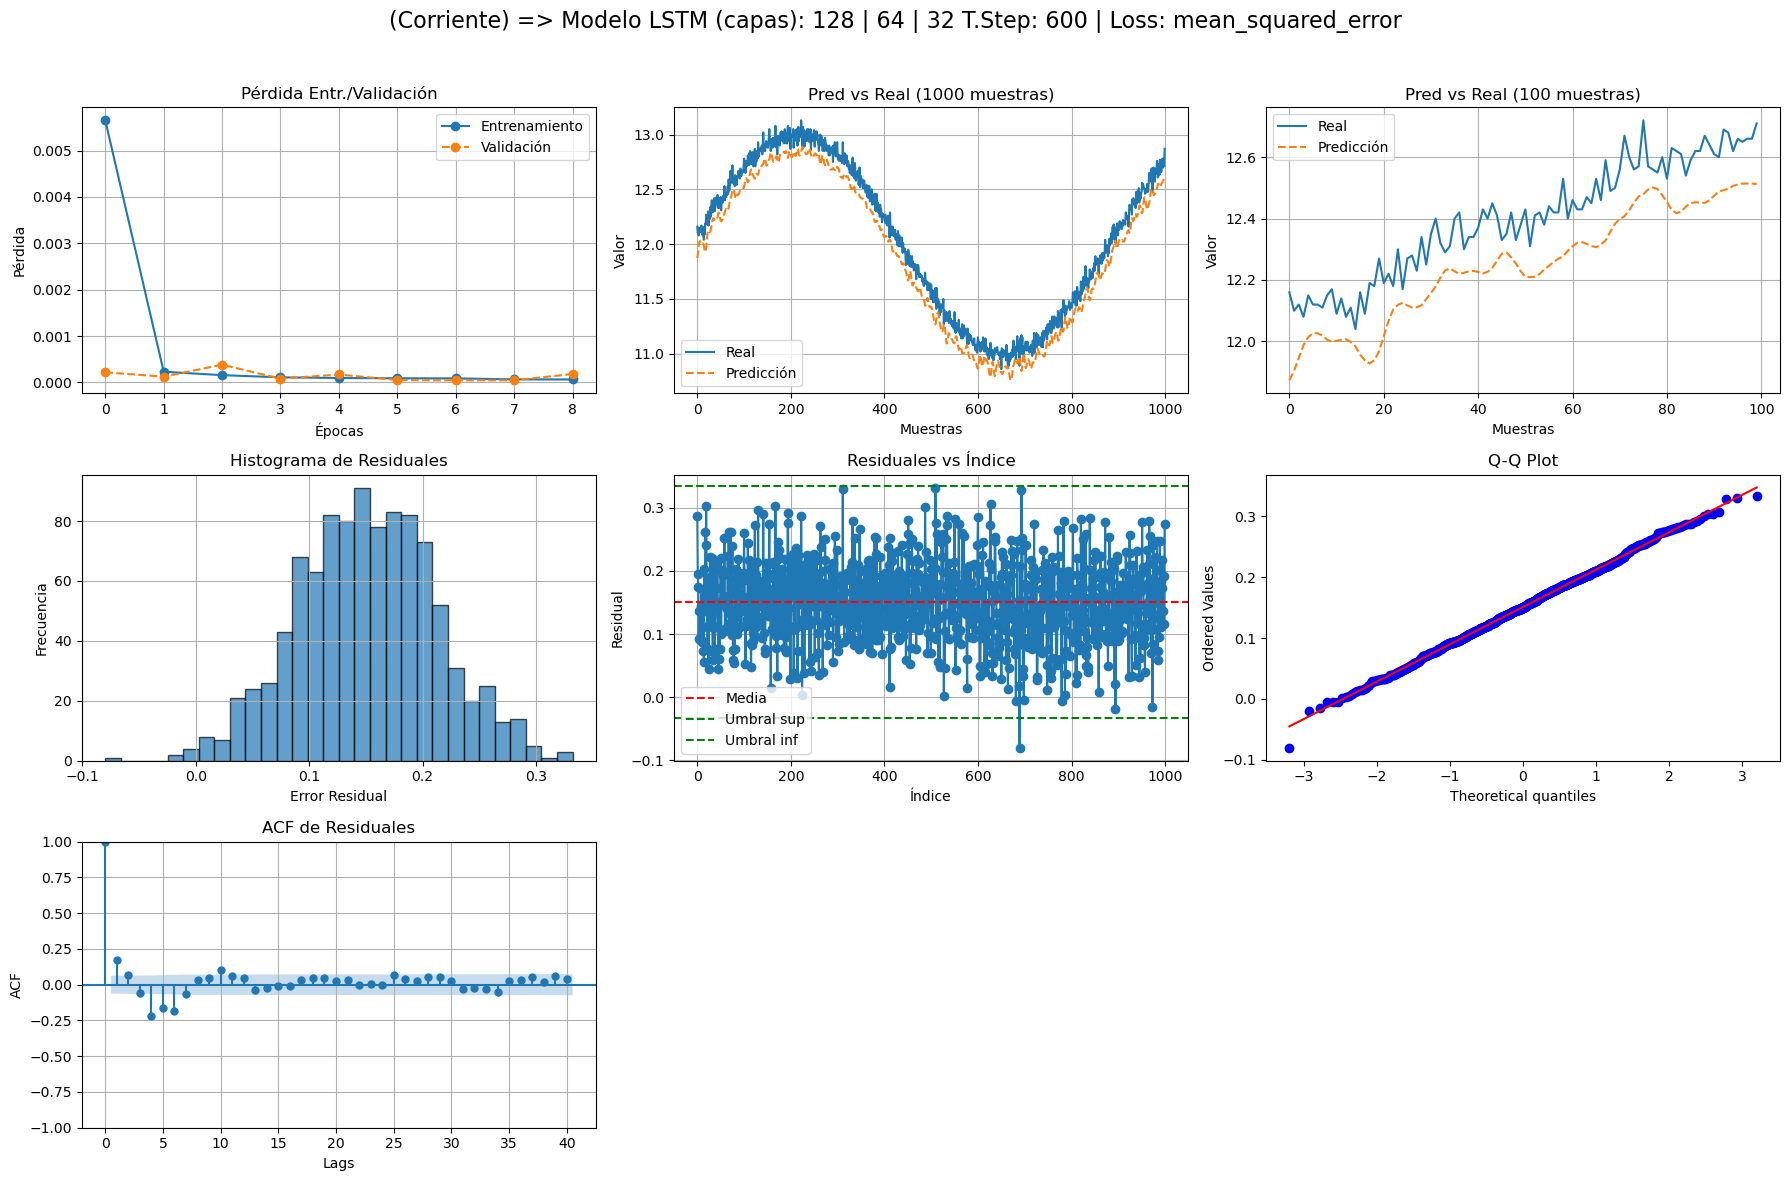

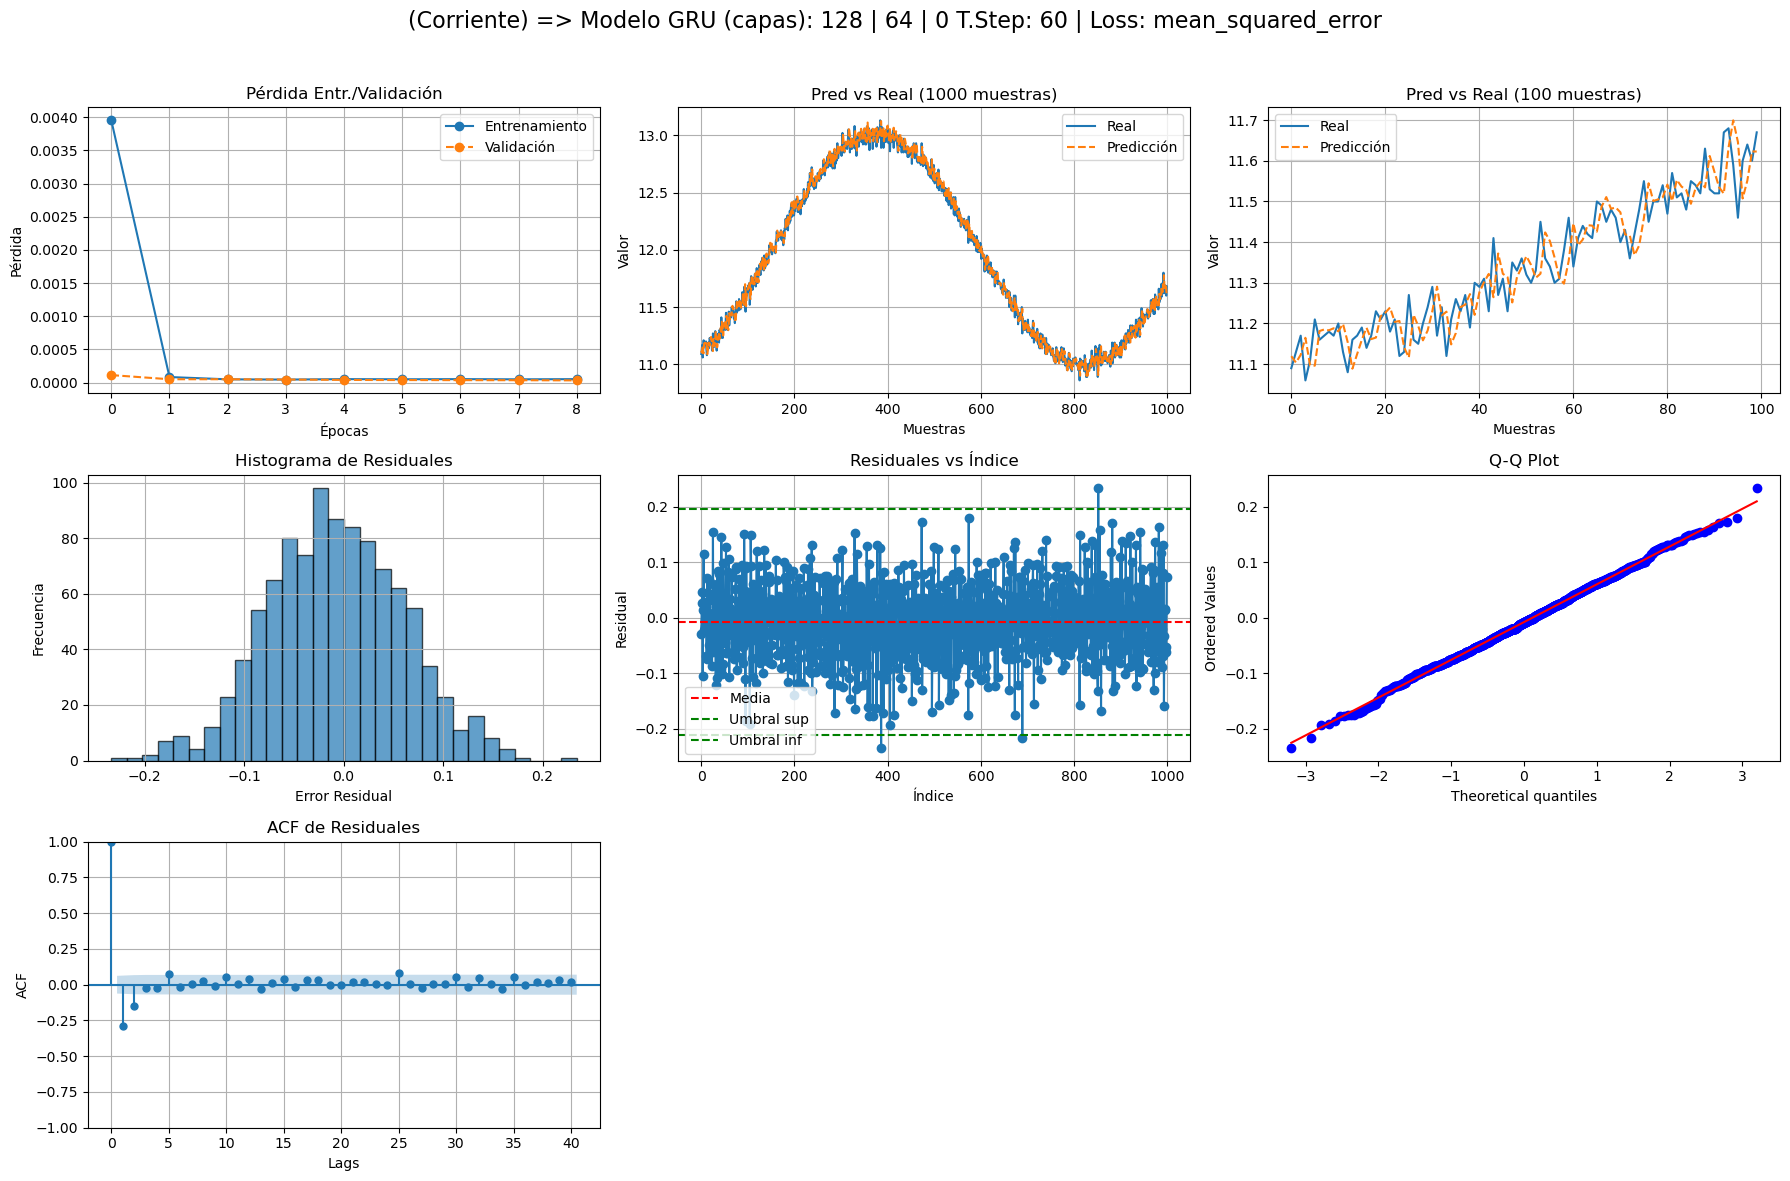

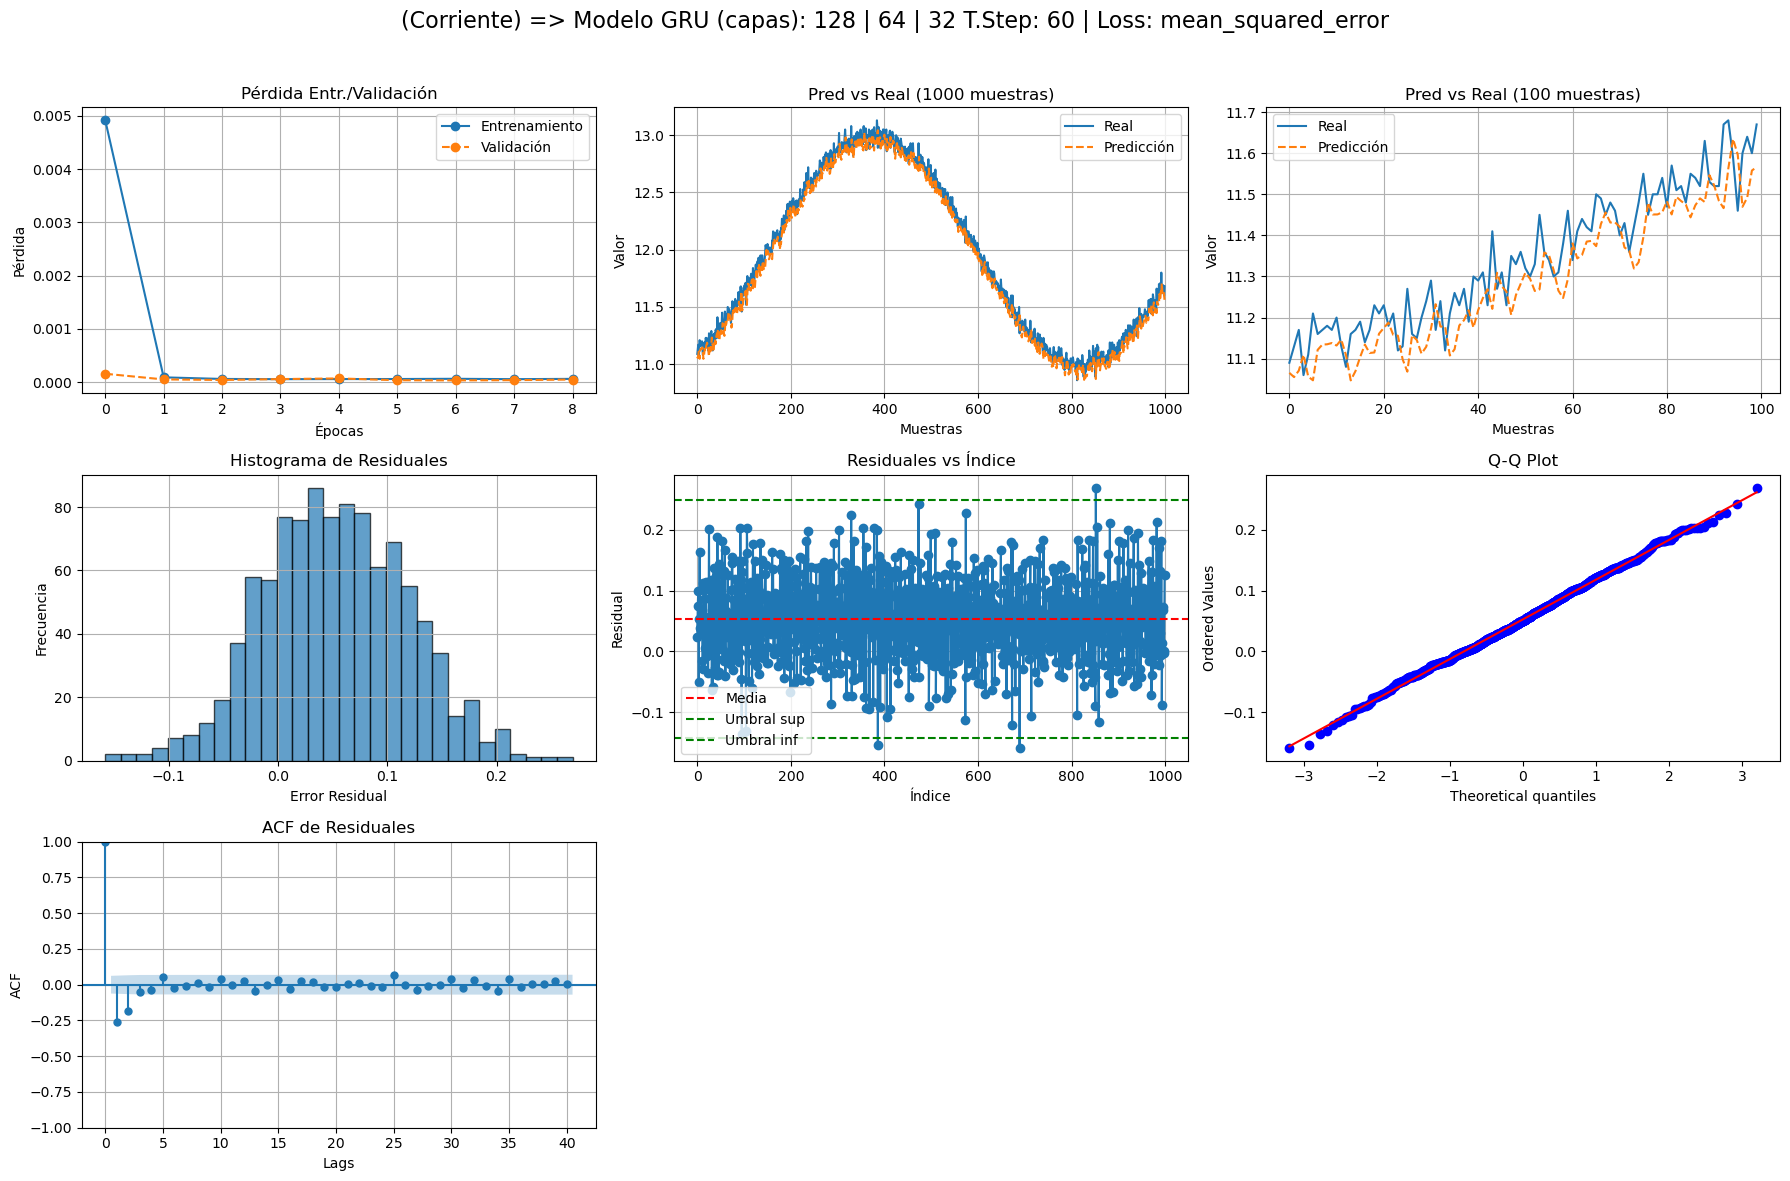

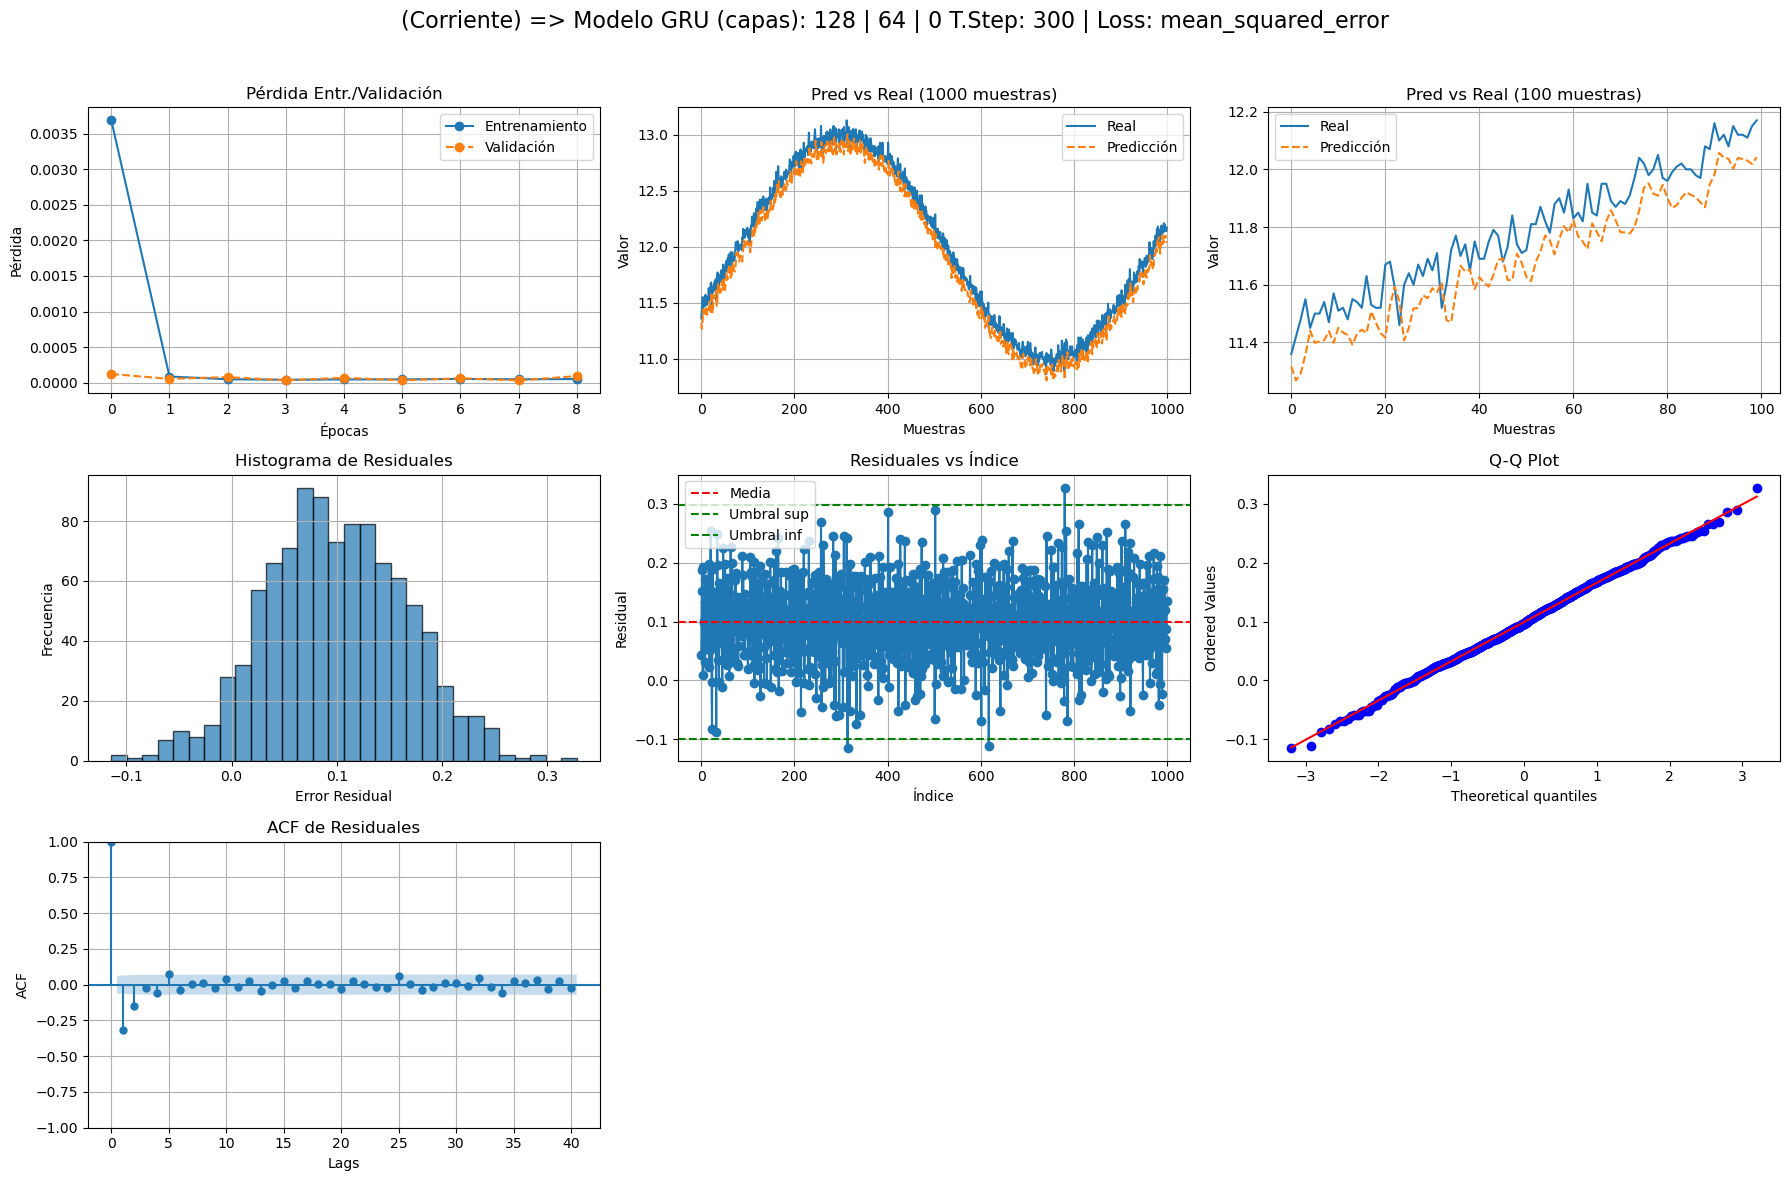

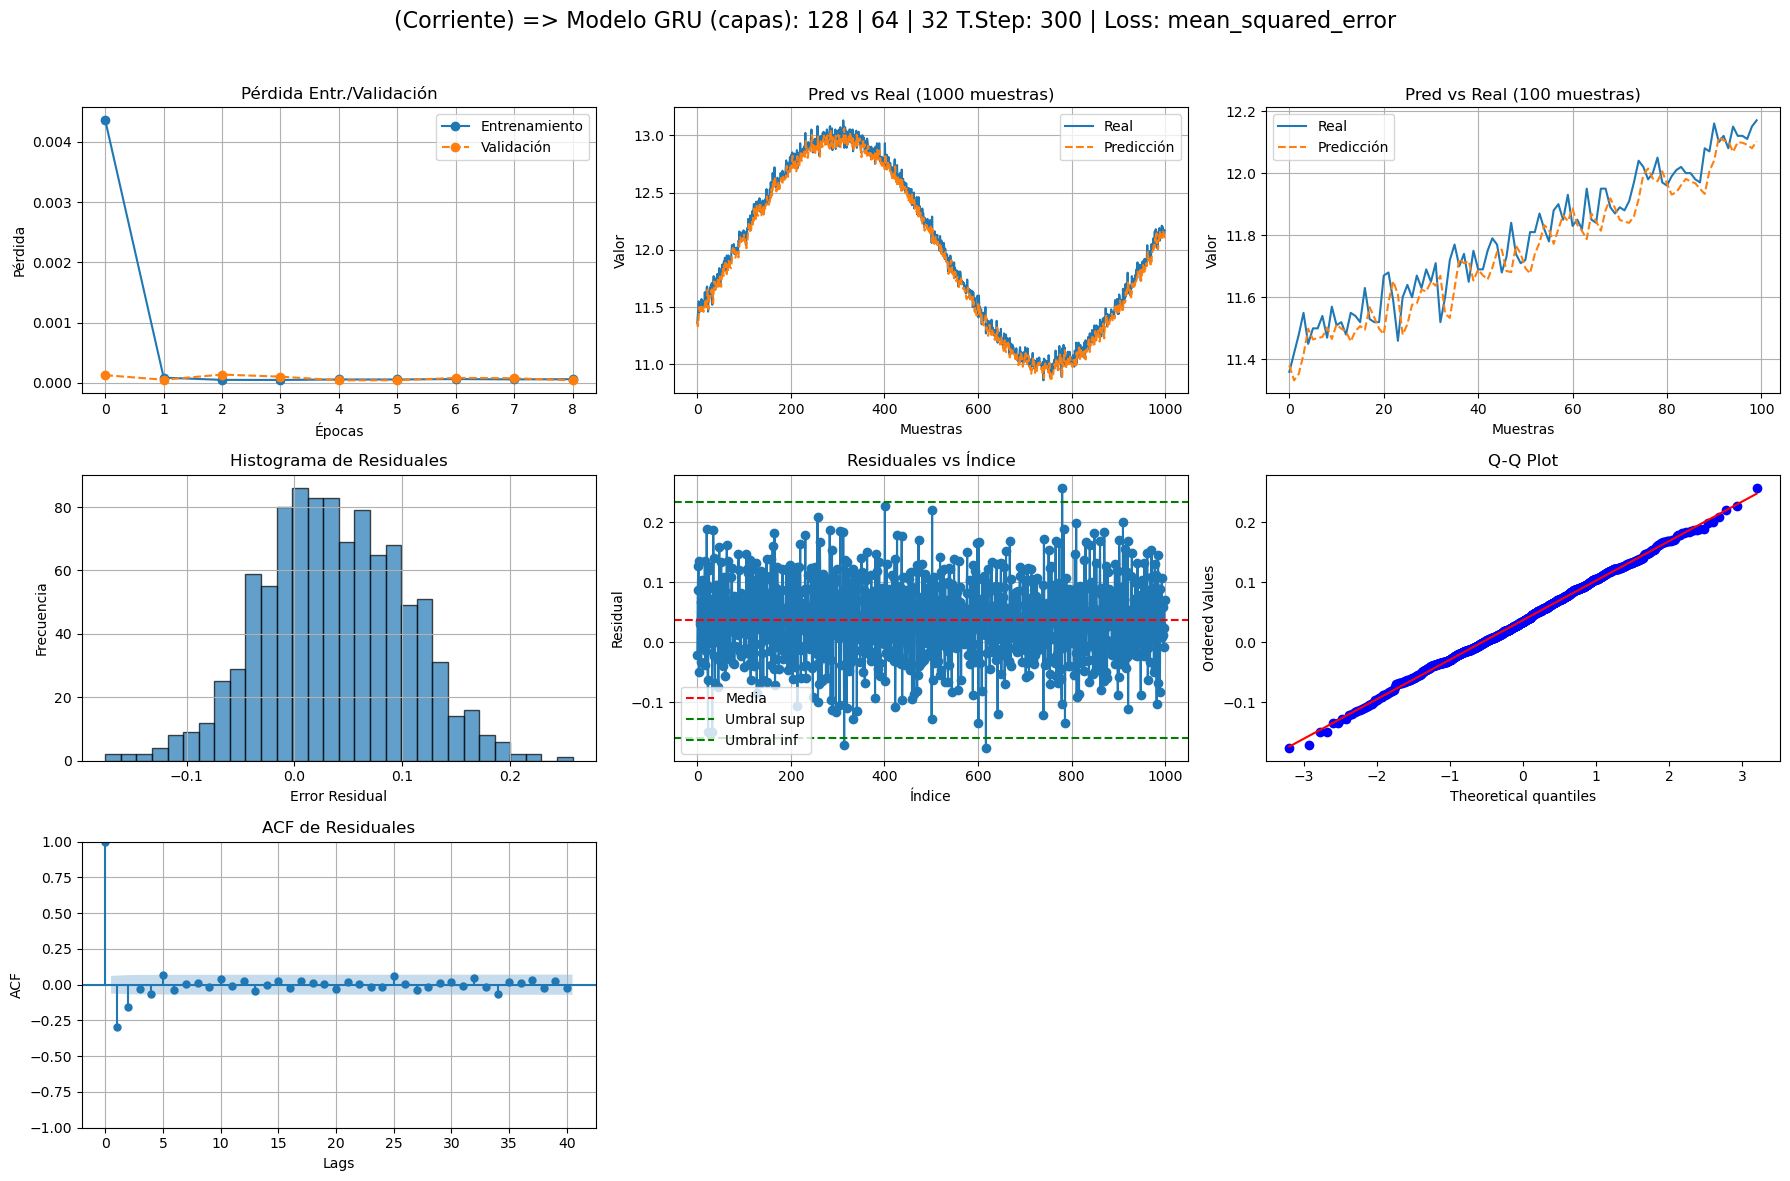

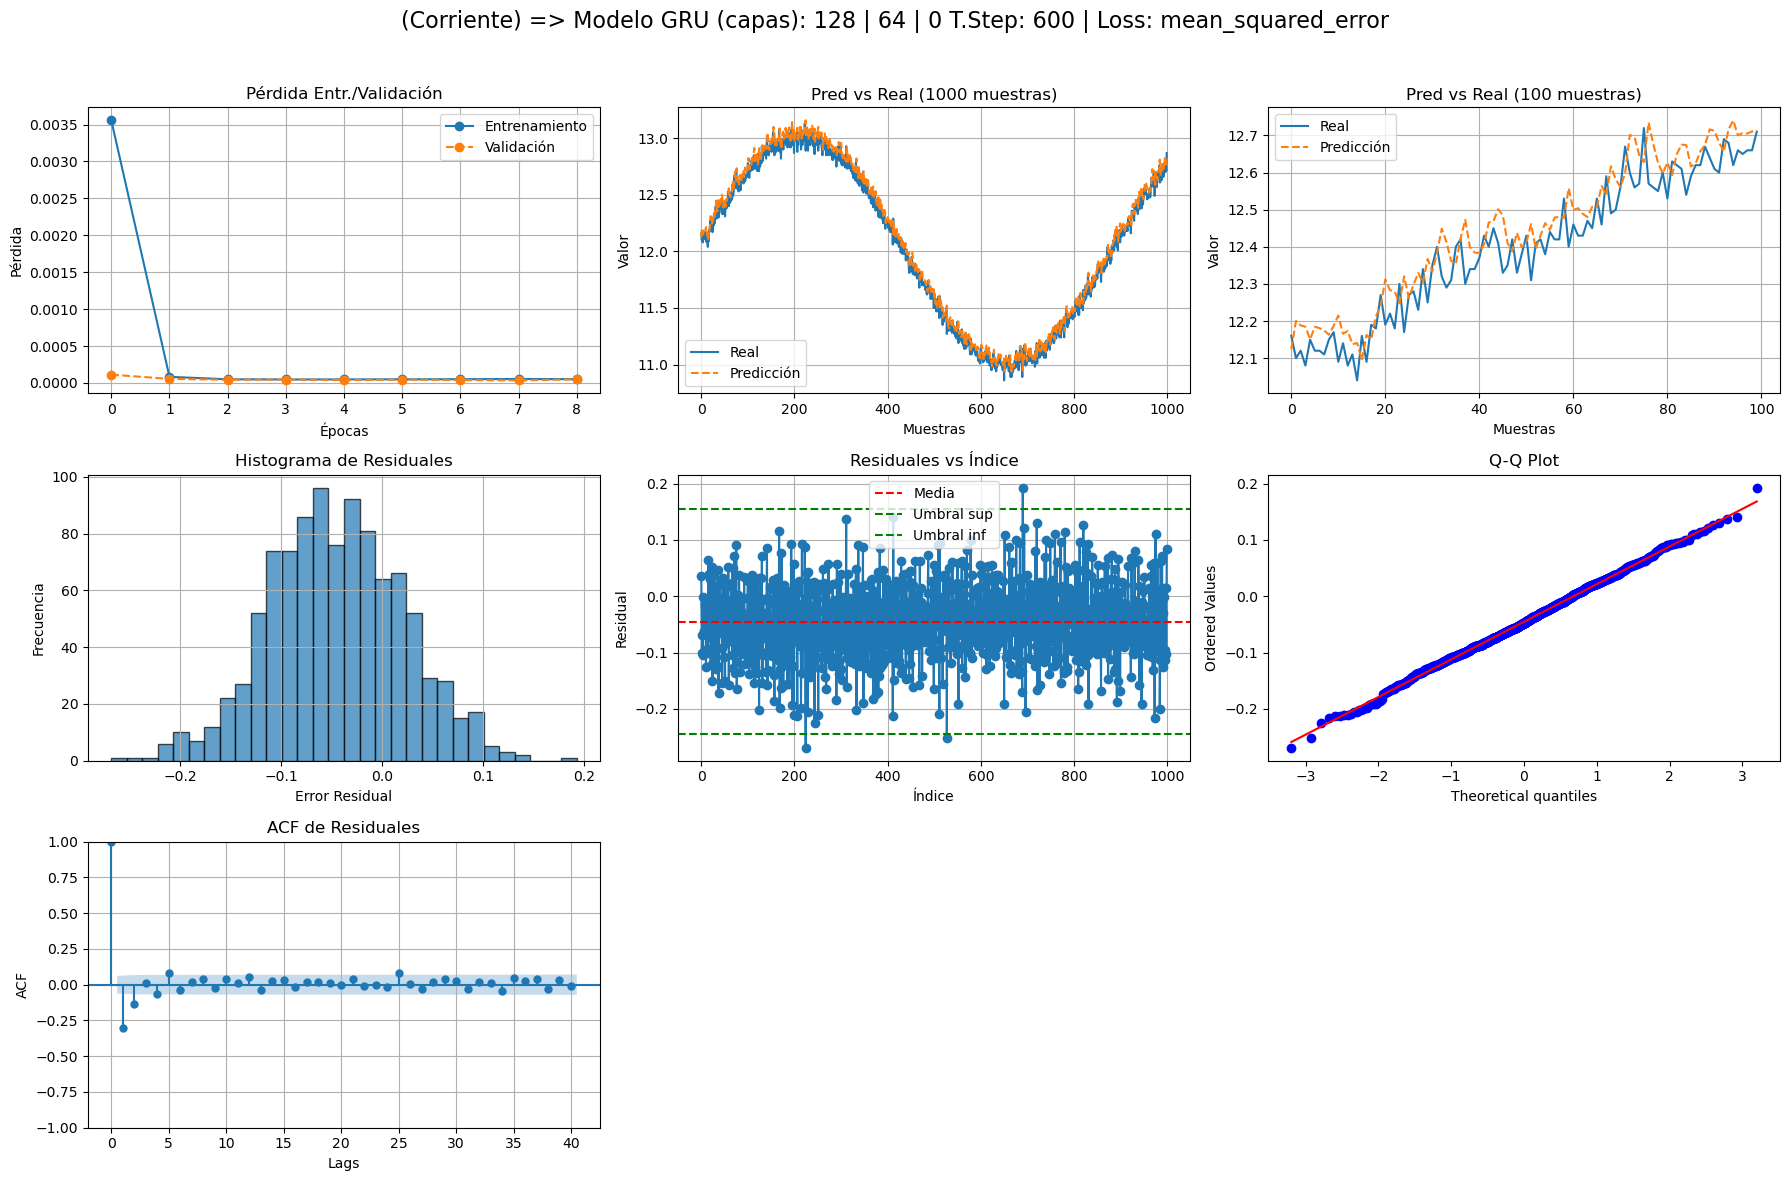

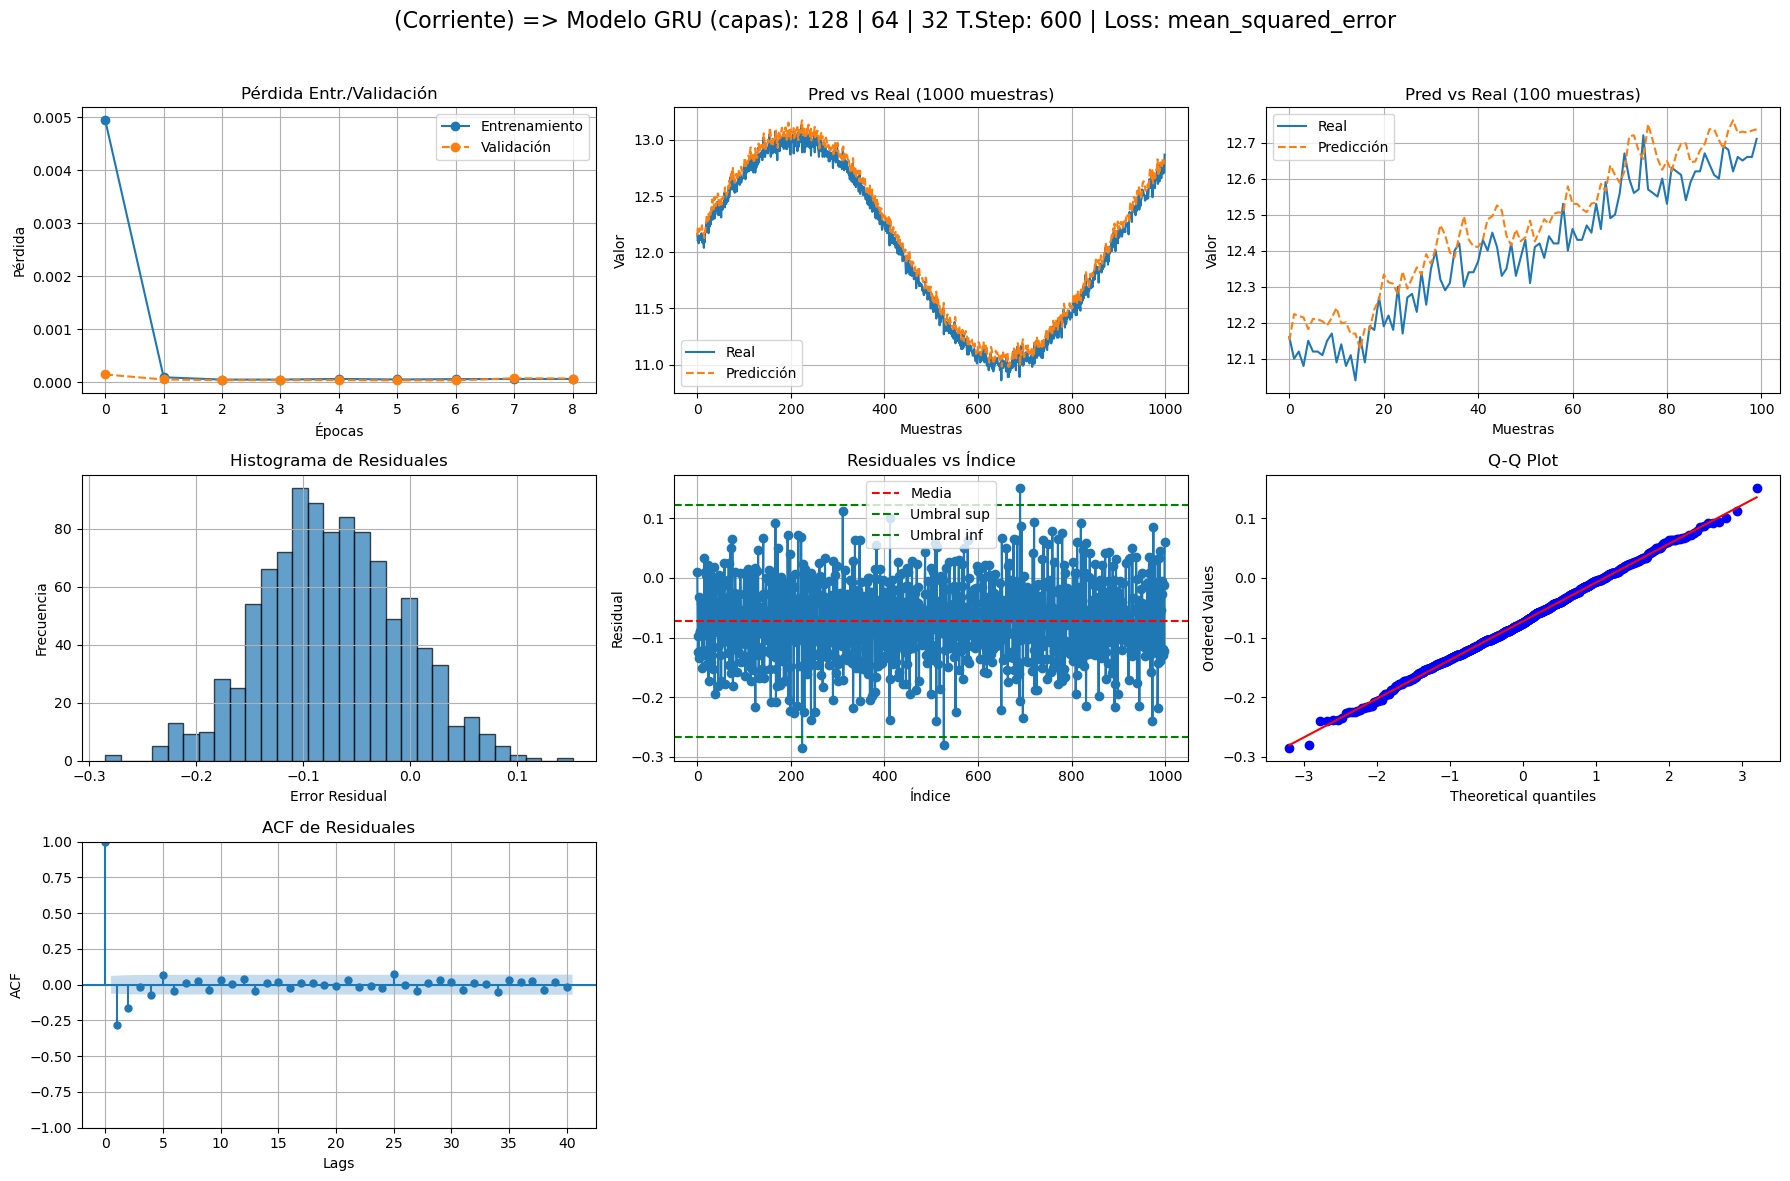

Resumen de Resultados por Modelo:
Modelo    Sensor     Capas  Time Step  Train Loss Final  Val Loss Final  Media Residuales  Desviación Residuales  Shapiro-Wilk      p-value  Puntos anómalos  Porcentaje anómalos (%)  Parametros     RMSE
  LSTM Vibracion  128|64|0         60          0.002576        0.002474         -0.021690               0.158987      0.850483 1.046130e-29               29                      2.9      116033 0.166118
  LSTM Vibracion 128|64|32         60          0.002511        0.002353         -0.000795               0.156782      0.850126 9.783562e-30               30                      3.0      128417 0.162003
  LSTM Vibracion  128|64|0        300          0.002568        0.002501         -0.019381               0.160718      0.850649 1.079243e-29               27                      2.7      116033 0.167023
  LSTM Vibracion 128|64|32        300          0.002576        0.003449         -0.092834               0.166714      0.879297 3.727292e-27               

In [16]:
# --- Resumen de Resultados por Modelo ---

# Número de muestras a usar en algunos cálculos
n_samples_1000 = 1000
n_samples_100 = 100

# Lista para almacenar el resumen de métricas por modelo
summary_data = []

# Iterar sobre cada modelo (asumimos que df_results es un DataFrame con la información de cada modelo)
for i in range(len(df_results)):
    # Extraer historial de pérdida
    history = df_results['Result'][i]['history'].history
    train_loss_final = history['loss'][-1]
    val_loss_final = history['val_loss'][-1]
    
    # Valores reales y predichos para 1000 y 100 muestras
    y_real_1000 = df_results['Result'][i]['y_test_inv'][:n_samples_1000, 0]
    y_pred_1000 = df_results['Result'][i]['y_pred_inv'][:n_samples_1000, 0]
    y_real_100 = df_results['Result'][i]['y_test_inv'][:n_samples_100, 0]
    y_pred_100 = df_results['Result'][i]['y_pred_inv'][:n_samples_100, 0]
    
    # Calcular residuales y sus métricas
    residuals = y_real_1000 - y_pred_1000
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    stat, p_value = stats.shapiro(residuals)
    
    # Umbrales para detectar anomalías (±3 desviaciones)
    umbral_sup = mean_res + 3 * std_res
    umbral_inf = mean_res - 3 * std_res
    anomalias = np.where((residuals > umbral_sup) | (residuals < umbral_inf))[0]
    porcentaje_anomalias = (len(anomalias) / len(residuals)) * 100
    
    # Crear etiqueta para el modelo
    model_label = f"({df_results['features'][i][0]}) => Modelo {df_results['Model'][i]} (capas): {df_results['Neurons1'][i]} | {df_results['Neurons2'][i]} | {df_results['Neurons3'][i]} T.Step: {df_results['Time Step'][i]} | Loss: {df_results['loss'][i]}"
    
    # Agregar métricas al resumen
    summary_data.append({
         "Modelo": df_results['Model'][i],
         "Sensor": df_results['features'][i][0],
         "Capas": f"{df_results['Neurons1'][i]}|{df_results['Neurons2'][i]}|{df_results['Neurons3'][i]}",
         "Time Step": df_results['Time Step'][i],
         "Train Loss Final": train_loss_final,
         "Val Loss Final": val_loss_final,
         "Media Residuales": mean_res,
         "Desviación Residuales": std_res,
         "Shapiro-Wilk": stat,
         "p-value": p_value,
         "Puntos anómalos": len(anomalias),
         "Porcentaje anómalos (%)": porcentaje_anomalias,
         "Parametros": df_results["Result"][i]["model"].count_params(),
         "RMSE": df_results['RMSE'][i]
    })
    
    # --- Crear figura unificada de todas las gráficas para el modelo ---
    # Usamos una cuadrícula de 3 filas x 3 columnas
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    # (0,0): Pérdida en entrenamiento y validación
    axs[0,0].plot(history['loss'], marker='o', label='Entrenamiento')
    axs[0,0].plot(history['val_loss'], marker='o', linestyle='--', label='Validación')
    axs[0,0].set_title("Pérdida Entr./Validación")
    axs[0,0].set_xlabel("Épocas")
    axs[0,0].set_ylabel("Pérdida")
    axs[0,0].legend()
    axs[0,0].grid(True)
    
    # (0,1): Predicción vs Real (1000 muestras)
    axs[0,1].plot(y_real_1000, label='Real')
    axs[0,1].plot(y_pred_1000, linestyle='--', label='Predicción')
    axs[0,1].set_title("Pred vs Real (1000 muestras)")
    axs[0,1].set_xlabel("Muestras")
    axs[0,1].set_ylabel("Valor")
    axs[0,1].legend()
    axs[0,1].grid(True)
    
    # (0,2): Predicción vs Real (100 muestras)
    axs[0,2].plot(y_real_100, label='Real')
    axs[0,2].plot(y_pred_100, linestyle='--', label='Predicción')
    axs[0,2].set_title("Pred vs Real (100 muestras)")
    axs[0,2].set_xlabel("Muestras")
    axs[0,2].set_ylabel("Valor")
    axs[0,2].legend()
    axs[0,2].grid(True)
    
    # (1,0): Histograma de Residuales
    axs[1,0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axs[1,0].set_title("Histograma de Residuales")
    axs[1,0].set_xlabel("Error Residual")
    axs[1,0].set_ylabel("Frecuencia")
    axs[1,0].grid(True)
    
    # (1,1): Residuales vs Índice con umbrales
    axs[1,1].plot(residuals, marker='o', linestyle='-')
    axs[1,1].axhline(mean_res, color='red', linestyle='--', label='Media')
    axs[1,1].axhline(umbral_sup, color='green', linestyle='--', label='Umbral sup')
    axs[1,1].axhline(umbral_inf, color='green', linestyle='--', label='Umbral inf')
    axs[1,1].set_title("Residuales vs Índice")
    axs[1,1].set_xlabel("Índice")
    axs[1,1].set_ylabel("Residual")
    axs[1,1].legend()
    axs[1,1].grid(True)
    
    # (1,2): Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axs[1,2])
    axs[1,2].set_title("Q-Q Plot")
    
    # (2,0): ACF de Residuales
    plot_acf(residuals, lags=40, ax=axs[2,0])
    axs[2,0].set_title("ACF de Residuales")
    axs[2,0].set_xlabel("Lags")
    axs[2,0].set_ylabel("ACF")
    axs[2,0].grid(True)
    
    # (2,1) y (2,2): Ocultar ejes vacíos
    axs[2,1].axis('off')
    axs[2,2].axis('off')
    
    # Título general para la figura del modelo
    fig.suptitle(model_label, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Imprimir el resumen comparativo en la terminal ---
df_summary = pd.DataFrame(summary_data)
print("Resumen de Resultados por Modelo:")
print(df_summary.to_string(index=False))


df_summary.columns()

## 14 Tabla de Resultados de los Modelos Ordenados por RSME de mejor a peor.

In [17]:
print("Resumen de Resultados por Modelo:")
print(df_summary.sort_values(by='RMSE', ascending=True)[[ "Sensor", "Modelo", "Capas", "Time Step","Parametros", "RMSE"]].to_markdown())

Resumen de Resultados por Modelo:
|    | Sensor    | Modelo   | Capas     |   Time Step |   Parametros |      RMSE |
|---:|:----------|:---------|:----------|------------:|-------------:|----------:|
| 18 | Corriente | GRU      | 128|64|0  |          60 |        87617 | 0.0715798 |
| 21 | Corriente | GRU      | 128|64|32 |         300 |        96993 | 0.0772963 |
| 15 | Corriente | LSTM     | 128|64|32 |         300 |       128417 | 0.0779421 |
| 22 | Corriente | GRU      | 128|64|0  |         600 |        87617 | 0.0846855 |
| 19 | Corriente | GRU      | 128|64|32 |          60 |        96993 | 0.0851868 |
| 12 | Corriente | LSTM     | 128|64|0  |          60 |       116033 | 0.0900009 |
| 14 | Corriente | LSTM     | 128|64|0  |         300 |       116033 | 0.0933659 |
| 13 | Corriente | LSTM     | 128|64|32 |          60 |       128417 | 0.0964514 |
| 23 | Corriente | GRU      | 128|64|32 |         600 |        96993 | 0.100245  |
| 20 | Corriente | GRU      | 128|64|0  |         300

In [18]:
df_summary

Modelo     Sensor      Capas  Time Step  Train Loss Final  Val Loss Final  \
0    LSTM  Vibracion   128|64|0         60          0.002576        0.002474   
1    LSTM  Vibracion  128|64|32         60          0.002511        0.002353   
2    LSTM  Vibracion   128|64|0        300          0.002568        0.002501   
3    LSTM  Vibracion  128|64|32        300          0.002576        0.003449   
4    LSTM  Vibracion   128|64|0        600          0.002572        0.002475   
5    LSTM  Vibracion  128|64|32        600          0.002550        0.002772   
6     GRU  Vibracion   128|64|0         60          0.002540        0.002423   
7     GRU  Vibracion  128|64|32         60          0.002571        0.002583   
8     GRU  Vibracion   128|64|0        300          0.002562        0.002711   
9     GRU  Vibracion  128|64|32        300          0.002556        0.002717   
10    GRU  Vibracion   128|64|0        600          0.002502        0.002408   
11    GRU  Vibracion  128|64|32        600          0.002556        0.002468   
12   LSTM  Corriente   128|64|0         60          0.000056        0.000054   
13   LSTM  Corriente  128|64|32         60          0.000071        0.000062   
14   LSTM  Corriente   128|64|0        300          0.000052        0.000058   
15   LSTM  Corriente  128|64|32        300          0.000068        0.000041   
16   LSTM  Corriente   128|64|0        600          0.000056        0.000120   
17   LSTM  Corriente  128|64|32        600          0.000063        0.000180   
18    GRU  Corriente   128|64|0         60          0.000053        0.000034   
19    GRU  Corriente  128|64|32         60          0.000061        0.000049   
20    GRU  Corriente   128|64|0        300          0.000053        0.000094   
21    GRU  Corriente  128|64|32        300          0.000060        0.000040   
22    GRU  Corriente   128|64|0        600          0.000051        0.000048   
23    GRU  Corriente  128|64|32        600          0.000060        0.000067   

    Media Residuales  Desviación Residuales  Shapiro-Wilk       p-value  \
0          -0.021690               0.158987      0.850483  1.046130e-29   
1          -0.000795               0.156782      0.850126  9.783562e-30   
2          -0.019381               0.160718      0.850649  1.079243e-29   
3          -0.092834               0.166714      0.879297  3.727292e-27   
4           0.004675               0.157207      0.867740  3.135197e-28   
5           0.059985               0.158450      0.876679  2.094628e-27   
6           0.008603               0.156288      0.856347  3.203700e-29   
7          -0.041412               0.157352      0.841791  2.117470e-30   
8           0.049957               0.160625      0.886444  1.891632e-26   
9          -0.042367               0.162286      0.870035  5.055627e-28   
10          0.023652               0.154235      0.825334  1.231619e-31   
11         -0.009898               0.155480      0.865920  2.156231e-28   
12         -0.050053               0.062714      0.998768  7.338218e-01   
13          0.065066               0.062464      0.999127  9.301120e-01   
14          0.064084               0.059356      0.998653  6.566893e-01   
15          0.018353               0.062823      0.999376  9.895559e-01   
16          0.117352               0.061030      0.999090  9.155082e-01   
17          0.150975               0.061182      0.998792  7.494443e-01   
18         -0.007796               0.067755      0.998834  7.765350e-01   
19          0.052802               0.065132      0.998446  5.201072e-01   
20          0.099128               0.066595      0.998684  6.778467e-01   
21          0.036866               0.065700      0.998562  5.953509e-01   
22         -0.045295               0.066607      0.998803  7.565805e-01   
23         -0.072634               0.064926      0.998722  7.034876e-01   

    Puntos anómalos  Porcentaje anómalos (%)  Parametros      RMSE  
0                29                      2.9      116033 

## 15. Gráficas y Resulatdos con formato más grande.

In [ ]:
# --- Resumen de Resultados por Modelo ---

# Número de muestras a usar en algunos cálculos
n_samples_1000 = 1000
n_samples_100 = 100

# Lista para almacenar el resumen de métricas por modelo
summary_data = []

# Iterar sobre cada modelo (asumimos que df_results es un DataFrame con la información de cada modelo)
for i in range(len(df_results)):
    # Extraer historial de pérdida
    history = df_results['Result'][i]['history'].history
    train_loss_final = history['loss'][-1]
    val_loss_final = history['val_loss'][-1]
    
    # Valores reales y predichos para 1000 y 100 muestras
    y_real_1000 = df_results['Result'][i]['y_test_inv'][:n_samples_1000, 0]
    y_pred_1000 = df_results['Result'][i]['y_pred_inv'][:n_samples_1000, 0]
    y_real_100 = df_results['Result'][i]['y_test_inv'][:n_samples_100, 0]
    y_pred_100 = df_results['Result'][i]['y_pred_inv'][:n_samples_100, 0]
    
    # Calcular residuales y sus métricas
    residuals = y_real_1000 - y_pred_1000
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    stat_val, p_value = stats.shapiro(residuals)
    
    # Umbrales para detectar anomalías (±3 desviaciones)
    umbral_sup = mean_res + 3 * std_res
    umbral_inf = mean_res - 3 * std_res
    anomalias = np.where((residuals > umbral_sup) | (residuals < umbral_inf))[0]
    porcentaje_anomalias = (len(anomalias) / len(residuals)) * 100
    
    # Crear etiqueta para el modelo
    model_label = f"({df_results['features'][i][0]}) => Modelo {df_results['Model'][i]} (capas): {df_results['Neurons1'][i]} | {df_results['Neurons2'][i]} | {df_results['Neurons3'][i]} T.Step: {df_results['Time Step'][i]} | Loss: {df_results['loss'][i]}"
    
    # Agregar métricas al resumen
    summary_data.append({
         "Modelo": df_results['Model'][i],
         "Sensor": df_results['features'][i][0],
         "Capas": f"{df_results['Neurons1'][i]}|{df_results['Neurons2'][i]}|{df_results['Neurons3'][i]}",
         "Time Step": df_results['Time Step'][i],
         "Train Loss Final": train_loss_final,
         "Val Loss Final": val_loss_final,
         "Media Residuales": mean_res,
         "Desviación Residuales": std_res,
         "Shapiro-Wilk": stat_val,
         "p-value": p_value,
         "Puntos anómalos": len(anomalias),
         "Porcentaje anómalos (%)": porcentaje_anomalias,
         "Parametros": df_results["Result"][i]["model"].count_params(),
         "RMSE": df_results['RMSE'][i]
    })
    
    # --- Crear figura unificada de todas las gráficas para el modelo en 7 filas x 1 columna ---
    fig, axs = plt.subplots(7, 1, figsize=(12, 28))
    
    # 1. Pérdida en entrenamiento y validación
    axs[0].plot(history['loss'], marker='o', label='Entrenamiento')
    axs[0].plot(history['val_loss'], marker='o', linestyle='--', label='Validación')
    axs[0].set_title("Pérdida Entr./Validación")
    axs[0].set_xlabel("Épocas")
    axs[0].set_ylabel("Pérdida")
    axs[0].legend()
    axs[0].grid(True)
    
    # 2. Predicción vs Real (1000 muestras)
    axs[1].plot(y_real_1000, label='Real')
    axs[1].plot(y_pred_1000, linestyle='--', label='Predicción')
    axs[1].set_title("Pred vs Real (1000 muestras)")
    axs[1].set_xlabel("Muestras")
    axs[1].set_ylabel("Valor")
    axs[1].legend()
    axs[1].grid(True)
    
    # 3. Predicción vs Real (100 muestras)
    axs[2].plot(y_real_100, label='Real')
    axs[2].plot(y_pred_100, linestyle='--', label='Predicción')
    axs[2].set_title("Pred vs Real (100 muestras)")
    axs[2].set_xlabel("Muestras")
    axs[2].set_ylabel("Valor")
    axs[2].legend()
    axs[2].grid(True)
    
    # 4. Histograma de Residuales
    axs[3].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axs[3].set_title("Histograma de Residuales")
    axs[3].set_xlabel("Error Residual")
    axs[3].set_ylabel("Frecuencia")
    axs[3].grid(True)
    
    # 5. Residuales vs Índice con umbrales
    axs[4].plot(residuals, marker='o', linestyle='-')
    axs[4].axhline(mean_res, color='red', linestyle='--', label='Media')
    axs[4].axhline(umbral_sup, color='green', linestyle='--', label='Umbral sup')
    axs[4].axhline(umbral_inf, color='green', linestyle='--', label='Umbral inf')
    axs[4].set_title("Residuales vs Índice")
    axs[4].set_xlabel("Índice")
    axs[4].set_ylabel("Residual")
    axs[4].legend()
    axs[4].grid(True)
    
    # 6. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axs[5])
    axs[5].set_title("Q-Q Plot")
    
    # 7. ACF de Residuales
    plot_acf(residuals, lags=40, ax=axs[6])
    axs[6].set_title("ACF de Residuales")
    axs[6].set_xlabel("Lags")
    axs[6].set_ylabel("ACF")
    axs[6].grid(True)
    
    # Título general para la figura del modelo
    fig.suptitle(model_label, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Imprimir el resumen comparativo en la terminal ---
df_summary = pd.DataFrame(summary_data)
print("Resumen de Resultados por Modelo:")
print(df_summary.to_string(index=False))


## 16. Guardamos Modelo con mejor resultado

In [20]:
# Guardar los modelos entrenados en la carpeta "modelos"

# Verificar (o crear) la carpeta "modelos"
folder = "modelos"
if not os.path.exists(folder):
    os.makedirs(folder)

# Obtener la lista única de features (asumimos que 'features' es una lista y tomamos el primer elemento)
unique_features = df_results['features'].apply(lambda x: x[0]).unique()

# Iterar sobre cada feature
for feature in unique_features:
    # Filtrar el DataFrame para la feature actual
    df_feature = df_results[df_results['features'].apply(lambda x: x[0]) == feature]
    
    # Ordenar por RMSE de forma ascendente (mejor rendimiento = menor RMSE)
    df_feature_sorted = df_feature.sort_values(by='RMSE')
    
    # Seleccionar los 2 mejores modelo
    top_models = df_feature_sorted.head(2)
    
    # Iterar sobre los modelos seleccionados
    for idx, row in top_models.iterrows():
        # Extraer el modelo Keras
        model_obj = row['Result']['model']
        
        # Construir el nombre de archivo:
        # - idx: índice del modelo en el DataFrame
        # - feature: nombre de la feature
        # - Modelo usado: se asume que está en la columna "Model" (ej. LSTM o GRU)
        # - Capas: concatenación de Neurons1, Neurons2, Neurons3 (ej. "128_64_0")
        # - Total de parámetros: formateado como "p####"
        model_used = row['Model']
        capas = f"{row['Neurons1']}_{row['Neurons2']}_{row['Neurons3']}_Ts_{row['Time Step']}"
        total_params = model_obj.count_params()
        
        # Nombre del modelo (con extensión .h5)
        model_name = f"{idx}_{feature}_{model_used}_{capas}_p{total_params}.h5"
        filepath = os.path.join(folder, model_name)
        
        # Guardar el modelo
        model_obj.save(filepath)
        print(f"Modelo guardado: {filepath}")


Modelo guardado: modelos/1_Vibracion_LSTM_128_64_32_Ts_60_p128417.h5
Modelo guardado: modelos/10_Vibracion_GRU_128_64_0_Ts_600_p87617.h5
Modelo guardado: modelos/18_Corriente_GRU_128_64_0_Ts_60_p87617.h5
Modelo guardado: modelos/21_Corriente_GRU_128_64_32_Ts_300_p96993.h5


/home/rabsedna/miniconda3/envs/tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# R2
from sklearn.metrics import r2_score
import pandas as pd

# Calcular R² y agregarlo al DataFrame para cada modelo
df_results["R2"] = df_results.apply(
    lambda row: r2_score(row["Result"]["y_test_inv"], row["Result"]["y_pred_inv"]), axis=1
)

# Crear una columna 'Capas' combinando las configuraciones de las neuronas
df_results["Capas"] = df_results.apply(
    lambda row: f"{row['Neurons1']}_{row['Neurons2']}_{row['Neurons3']}", axis=1
)

# Extraer la feature (se asume que 'features' es una lista y se toma el primer elemento)
df_results["Feature"] = df_results["features"].apply(lambda x: x[0] if isinstance(x, list) else x)

# Reiniciar el índice para tener un consecutivo y renombrarlo
df_results_ordered = df_results.reset_index().rename(columns={'index': 'Consecutivo'})

# Seleccionar las columnas deseadas y reordenarlas
columnas = ["Consecutivo", "Feature", "Model", "RMSE", "R2", "Capas", "Time Step", "loss"]
df_results_ordered = df_results_ordered[columnas]

# Ordenar la tabla de mayor a menor R²
df_results_ordered = df_results_ordered.sort_values(by="R2", ascending=False)

# Mostrar la tabla completa
df_results_ordered



Consecutivo    Feature Model      RMSE        R2      Capas  Time Step  \
18           18  Corriente   GRU  0.071580  0.997333   128_64_0         60   
21           21  Corriente   GRU  0.077296  0.996900  128_64_32        300   
15           15  Corriente  LSTM  0.077942  0.996848  128_64_32        300   
22           22  Corriente   GRU  0.084685  0.996298   128_64_0        600   
19           19  Corriente   GRU  0.085187  0.996223  128_64_32         60   
12           12  Corriente  LSTM  0.090001  0.995783   128_64_0         60   
14           14  Corriente  LSTM  0.093366  0.995478   128_64_0        300   
13           13  Corriente  LSTM  0.096451  0.995157  128_64_32         60   
23           23  Corriente   GRU  0.100245  0.994813  128_64_32        600   
20           20  Corriente   GRU  0.118540  0.992710   128_64_0        300   
16           16  Corriente  LSTM  0.133982  0.990734   128_64_0        600   
17           17  Corriente  LSTM  0.163969  0.986123  128_64_32        600   
1             1  Vibracion  LSTM  0.162003  0.895448  128_64_32         60   
10           10  Vibracion   GRU  0.163886  0.893099   128_64_0        600   
6             6  Vibracion   GRU  0.164417  0.892308   128_64_0         60   
11           11  Vibracion   GRU  0.165936  0.890409  128_64_32        600   
4             4  Vibracion  LSTM  0.166152  0.890123   128_64_0        600   
0             0  Vibracion  LSTM  0.166118  0.890068   128_64_0         60   
2             2  Vibracion  LSTM  0.167023  0.888699   128_64_0        300   
7             7  Vibracion   GRU  0.169734  0.885231  128_64_32         60   
8             8  Vibracion   GRU  0.173914  0.879325   128_64_0        300   
9             9  Vibracion   GRU  0.174108  0.879055  128_64_32        300   
5             5  Vibracion  LSTM  0.175863  0.876904  128_64_32        600   
3             3  Vibracion  LSTM  0.196159  0.846479  128_64_32        300   

                  loss  
18  mean_squared_error  
21  mean_squared_error  
15  mean_squared_error  
22  mean_squared_error  
19  mean_squared_error  
12  mean_squared_error  
14  mean_squared_error  
13  mean_squared_error  
23  mean_squared_error  
20  mean_squared_error  
16  mean_squared_error  
17  mean_squared_error  
1   mean_squared_error  
10  mean_squared_error  
6   mean_squared_error  
11  mean_squared_error  
4   mean_squared_error  
0   mean_squared_error  
2   mean_squared_error  
7   mean_squared_error  
8   mean_squared_error  
9   mean_squared_error  
5   mean_squared_error  
3   mean_squared_error